In [22]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from CGCNN_MT.predict import main as predict_main
import sys
sys.path.append("./CGCNN_MT")
# import matplotlib; matplotlib.use('Agg')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ML results

In [23]:
model_root_dir = "./ML/models"
model_root_dir = Path(model_root_dir)

cls_tasks = ["SSD", "WS24"]
reg_tasks = ["TSD"]
all_metrics = {}
for task_set, tp in zip([cls_tasks, reg_tasks], ["cls", "reg"]):
    dfs = []
    for task in task_set:
        model_dir = model_root_dir / task/ "RAC_and_zeo_features_with_id_prop"
        for subdir in model_dir.iterdir():
            if not subdir.is_dir():
                continue
            model_metrics_file = subdir / "model_metrics.csv"
            df_metrics = pd.read_csv(model_metrics_file, index_col=0)
            keep_cols = [col for col in df_metrics.columns if "tr_" not in col and "val_" not in col]
            df_metrics = df_metrics.loc[["mean"], keep_cols].copy()
            df_metrics = df_metrics[~df_metrics["model_name"].isin(["XGBClassifier", "XGBRegressor", "LogisticRegression", "LinearRegression"])]
            df_metrics.insert(0, "Task", "_".join([task, subdir.name]).replace("_label", "").replace("_Label", ""))

            dfs.append(df_metrics)
            if tp == "cls":
                df_metrics.sort_values(by=["te_AUC"], inplace=True, ascending=False)
            else:
                df_metrics.sort_values(by=["te_MAE"], inplace=True)
            df_metrics.columns = [col.replace("te_", "") for col in df_metrics.columns]
            all_metrics[task + "_" + subdir.name] = df_metrics.to_dict("records")[0]

    # df_metrics_all = pd.concat(dfs)
    # df_metrics_all.index.name = "epoch"
    # df_metrics_all.reset_index(inplace=True)
    # df_metrics_all.sort_values(by=["Task", "model_name", "epoch"], inplace=True)
    # df_metrics_all.to_csv(model_root_dir/f"model_metrics_{tp}.csv", index=False)

keep_cols = ["Task", "R2", "MAE", "ACC", "BACC", "AUC", "model_name"]
df_ml_our = pd.DataFrame(all_metrics).T.copy()
df_ml_our = df_ml_our[keep_cols]
df_ml_our.insert(0, "Model", "ML_retrained")
df_ml_our = df_ml_our.rename(columns={'AUC': 'AUROC', "model_name": "Algorithm"}).reset_index(drop=True)
df_ml_our["Algorithm"] = df_ml_our["Algorithm"].map(lambda x: "RF" if "RandomForest" in x else "GP")
df_ml_our.set_index(["Task", "Model"], inplace=True)
df_ml_our

,,R2,MAE,ACC,BACC,AUROC,Algorithm
Task,Model,,,,,,
SSD,ML_retrained,NaN,NaN,0.7615,0.7261,0.8342,RF
WS24_water4,ML_retrained,NaN,NaN,0.6393,0.5154,0.8479,RF
WS24_boiling,ML_retrained,NaN,NaN,0.7308,0.7308,0.6805,RF
WS24_acid,ML_retrained,NaN,NaN,0.8056,0.8056,0.9198,GP
WS24_water,ML_retrained,NaN,NaN,0.7123,0.6868,0.7697,RF
WS24_base,ML_retrained,NaN,NaN,0.7083,0.7083,0.7431,GP
TSD,ML_retrained,0.465726060341605,45.4287514910119,NaN,NaN,NaN,RF


In [24]:
metrics_ref_dir = "./raw_data/WS24v2/models/metrics"
metrics_ref_dir = Path(metrics_ref_dir)
label2task_map = {
    "water_label": "WS24_water",
    "4_class_water_label": "WS24_water4",
    "acid_label": "WS24_acid",
    "base_label": "WS24_base",
    "boiling_label": "WS24_boiling",
}

saved_dir = Path("./CGCNN_MT/evaluation")

In [25]:
## ML results from Terrones et al. 2024(10.1021/jacs.4c05879)
all_metrics = []
# for d in [metrics_ours_dir, metrics_ref_dir]:
for d in [metrics_ref_dir]:
    for file in d.glob('*.txt'):
        label_name = file.stem.replace("mean_metrics_", "")
        with open(file, 'r') as f:
            lines = f.readlines()
        metrics = {}
        for line in lines:
            metric_name, metric_value = line.strip().split(": ")
            if "test" in metric_name and "mean" in metric_name:
                metric_value = float(metric_value)
                metric_name = metric_name.replace("-mean", "")
                metric_name = metric_name.replace("test_", "")
                # print(f"{label_name}: {metric_name}: {metric_value}")
                metrics.update({metric_name: metric_value})
        metrics.update({"Task": label2task_map[label_name], "Model": d.name})
    
        all_metrics.append(metrics)

group_map = {"metrics": "Terrones2024"}
df_ml_terrones = pd.DataFrame(all_metrics)
df_ml_terrones.rename(columns={'acc': 'ACC', 'bal_acc': 'BACC', 'roc_auc': 'AUROC'}, inplace=True)
df_ml_terrones["Model"] = df_ml_terrones["Model"].apply(lambda x: group_map[x])
df_ml_terrones.set_index(["Task", "Model"], inplace=True)
df_ml_terrones.sort_index(level=0, inplace=True)
df_ml_terrones.drop(columns=["AP", "F1"], inplace=True)
df_ml_terrones["Algorithm"] = "RF"
df_ml_terrones

,,ACC,BACC,AUROC,Algorithm
Task,Model,,,,
WS24_acid,Terrones2024,0.780556,0.780556,0.850772,RF
WS24_base,Terrones2024,0.704000,0.703526,0.780769,RF
WS24_boiling,Terrones2024,0.648148,0.648901,0.693956,RF
WS24_water,Terrones2024,0.768493,0.742705,0.828500,RF
WS24_water4,Terrones2024,0.655251,0.512478,0.816146,RF


In [26]:
## ML results from Nandy et al. 2021(10.1021/jacs.1c07217)
df_ml_nandy = pd.DataFrame(
    [
        {   
            "Task": "TSD",
            "Model": "Nandy2021",
            "R2": 0.46,
            "MAE": 44

        },
        {   
            "Task": "SSD",
            "Model": "Nandy2021",
            "ACC": 0.76,
            "AUROC": 0.81,
        },
        

    ]
)
df_ml_nandy.set_index(["Task", "Model"], inplace=True)
df_ml_nandy["Algorithm"] = "GP"
df_ml_nandy

,,R2,MAE,ACC,AUROC,Algorithm
Task,Model,,,,,
TSD,Nandy2021,0.46,44.0,NaN,NaN,GP
SSD,Nandy2021,NaN,NaN,0.76,0.81,GP


In [27]:
df_metrics = pd.concat([df_ml_our, df_ml_nandy, df_ml_terrones])
df_metrics.sort_index(inplace=True)
for col in ["R2", "MAE", "ACC", "BACC", "AUROC"]:
    df_metrics[col] = df_metrics[col].apply(lambda x: round(float(x), 2))   


df_metrics = df_metrics.reset_index()
df_metrics["Task"] = df_metrics["Task"].apply(lambda x: str(x).strip())
df_metrics.set_index(["Task", "Model"], inplace=True)

df_metrics.to_excel(saved_dir/"ML_results_test.xlsx")

df_metrics

R2    MAE   ACC  BACC  AUROC Algorithm
Task         Model                                                 
SSD          ML_retrained   NaN    NaN  0.76  0.73   0.83        RF
             Nandy2021      NaN    NaN  0.76   NaN   0.81        GP
TSD          ML_retrained  0.47  45.43   NaN   NaN    NaN        RF
             Nandy2021     0.46  44.00   NaN   NaN    NaN        GP
WS24_acid    ML_retrained   NaN    NaN  0.81  0.81   0.92        GP
             Terrones2024   NaN    NaN  0.78  0.78   0.85        RF
WS24_base    ML_retrained   NaN    NaN  0.71  0.71   0.74        GP
             Terrones2024   NaN    NaN  0.70  0.70   0.78        RF
WS24_boiling ML_retrained   NaN    NaN  0.73  0.73   0.68        RF
             Terrones2024   NaN    NaN  0.65  0.65   0.69        RF
WS24_water   ML_retrained   NaN    NaN  0.71  0.69   0.77        RF
             Terrones2024   NaN    NaN  0.77  0.74   0.83        RF
WS24_water4  ML_retrained   NaN    NaN  0.64  0.52   0.85        RF
             Terrones2024   NaN    NaN  0.66  0.51   0.82        RF

## Single task CGCNN and CGCNN-MT results analysis

In [28]:
task2models = {'TSD': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/TSD_seed42_cgcnn_raw/version_29'},
 'SSD': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/SSD_seed42_cgcnn_raw/version_4'},
 'WS24_water': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_water_seed42_cgcnn_raw/version_29'},
 'WS24_water4': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_water4_seed42_cgcnn_raw/version_3'},
 'WS24_acid': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_acid_seed42_cgcnn_raw/version_47'},
 'WS24_base': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_base_seed42_cgcnn_raw/version_0'},
 'WS24_boiling': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_boiling_seed42_cgcnn_raw/version_7'},
 'TSD_SSD_WS24_all': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw/version_24'},
 'TSD_SSD_WS24_all_attn': {'Model': 'att_cgcnn',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_43'}}

task_types:  ['regression']


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
Missing logger folder: logs/lightning_logs


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 14
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 144
extra_fea_len: 16
h_fea_len: 288
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggrega

2024-08-16 14:32:22.396972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 14:32:22.469244: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: |          | 0/? [00:00<?, ?it/s]

(40,) (40,)
TSD/external_test_R2Score: 0.4137, TSD/external_test_MeanAbsoluteError: 49.9903


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/TSD_seed42_cgcnn_raw@version_29/external_test_metrics.csv
task_types:  ['regression']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 14
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 144
extra_fea_len: 16
h_fea_len: 288
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggrega

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/SSD_seed42_cgcnn_raw@version_4/external_test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 272
extra_fea_len: 16
h_fea_len: 32
n_conv: 6
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha:

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 5
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 240
extra_fea_len: 16
h_fea_len: 80
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggregati

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9

Metrics saved to CGCNN_MT/evaluation/WS24_water_seed42_cgcnn_raw@version_29/external_test_metrics.csv
task_types:  ['classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 4
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 48
extra_fea_len: 16
h_fea_len: 208
n_conv: 6
n_h: 6
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
d

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9

Metrics saved to CGCNN_MT/evaluation/WS24_water4_seed42_cgcnn_raw@version_3/external_test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 208
extra_fea_len: 16
h_fea_len: 144
n_conv: 4
n_h: 4
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
d

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9

Metrics saved to CGCNN_MT/evaluation/WS24_acid_seed42_cgcnn_raw@version_47/external_test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 160
extra_fea_len: 16
h_fea_len: 160
n_conv: 7
n_h: 8
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9

Metrics saved to CGCNN_MT/evaluation/WS24_base_seed42_cgcnn_raw@version_0/external_test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 2
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 32
extra_fea_len: 16
h_fea_len: 48
n_conv: 1
n_h: 7
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_al

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/WS24_boiling_seed42_cgcnn_raw@version_7/external_test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 128
extra_fea_len: 16
h_f

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


(40,) (40,)
TSD/external_test_R2Score: 0.4378, TSD/external_test_MeanAbsoluteError: 51.1142
Predicting SSD...
prop_cols: ['ss_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/external_test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_nam

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/zhangsd/repos/MOFSNN/CGCNN_MT/module/module_utils.py:150: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/external_test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: 

Predicting: |          | 0/? [00:00<?, ?it/s]

(40,) (40,)
TSD/external_test_R2Score: 0.4897, TSD/external_test_MeanAbsoluteError: 45.5857


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting SSD...
prop_cols: ['ss_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/external_test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: 

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/external_test_metrics.csv
task_types:  ['regression']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 14
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 144
extra_fea_len: 16
h_fea_len: 288
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
a

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4335, TSD/test_MeanAbsoluteError: 45.3843


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/TSD_seed42_cgcnn_raw@version_29/test_metrics.csv
task_types:  ['regression']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 14
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 144
extra_fea_len: 16
h_fea_len: 288
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_l

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 272
extra_fea_len: 16
h_fea_len: 32
n_conv: 6
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggregat

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/SSD_seed42_cgcnn_raw@version_4/test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 272
extra_fea_len: 16
h_fea_len: 32
n_conv: 6
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 5
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 240
extra_fea_len: 16
h_fea_len: 80
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggregati

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If you

Metrics saved to CGCNN_MT/evaluation/WS24_water_seed42_cgcnn_raw@version_29/test_metrics.csv
task_types:  ['classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 4
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 48
extra_fea_len: 16
h_fea_len: 208
n_conv: 6
n_h: 6
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha:

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If you

Metrics saved to CGCNN_MT/evaluation/WS24_water4_seed42_cgcnn_raw@version_3/test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 208
extra_fea_len: 16
h_fea_len: 144
n_conv: 4
n_h: 4
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha:

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/WS24_acid_seed42_cgcnn_raw@version_47/test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 160
extra_fea_len: 16
h_fea_len: 160
n_conv: 7
n_h: 8
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 160
extra_fea_len: 16
h_fea_len: 160
n_conv: 7
n_h: 8
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggregat

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If you

Metrics saved to CGCNN_MT/evaluation/WS24_base_seed42_cgcnn_raw@version_0/test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 2
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 32
extra_fea_len: 16
h_fea_len: 48
n_conv: 1
n_h: 7
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/WS24_boiling_seed42_cgcnn_raw@version_7/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 128
extra_fea_len: 16
h_fea_len: 1

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.3470, TSD/test_MeanAbsoluteError: 48.0305


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4484, TSD/test_MeanAbsoluteError: 45.1970


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv


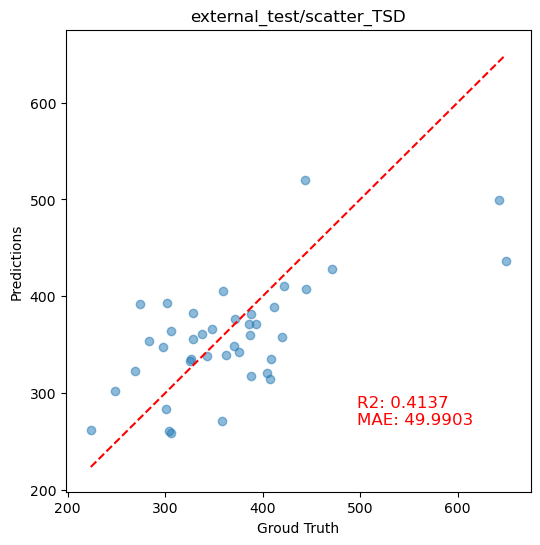

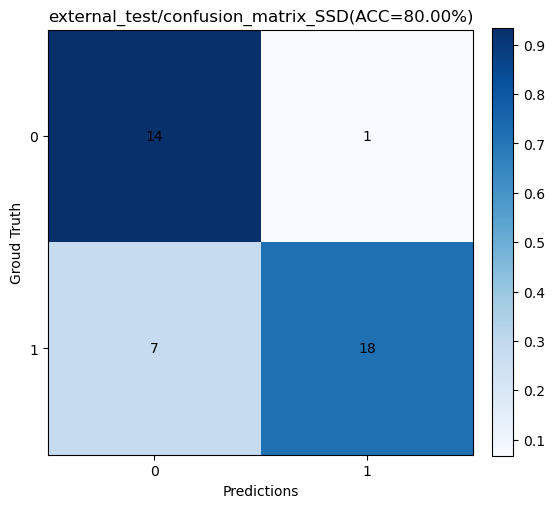

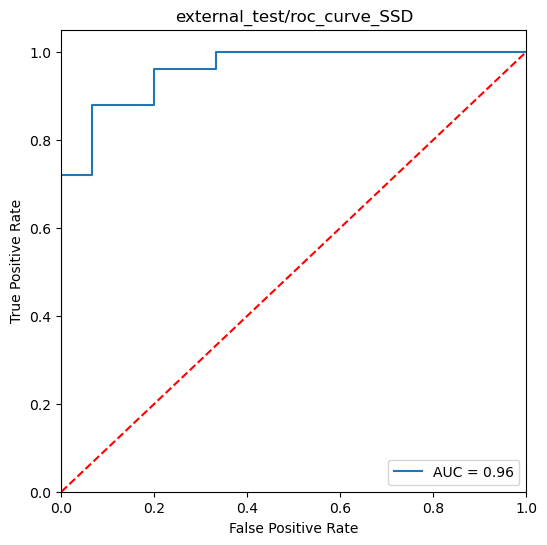

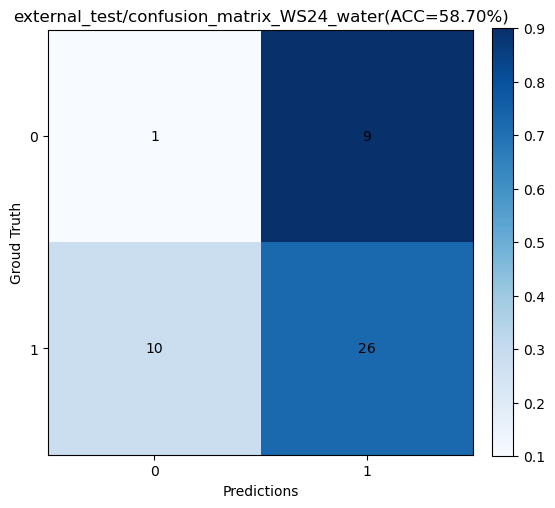

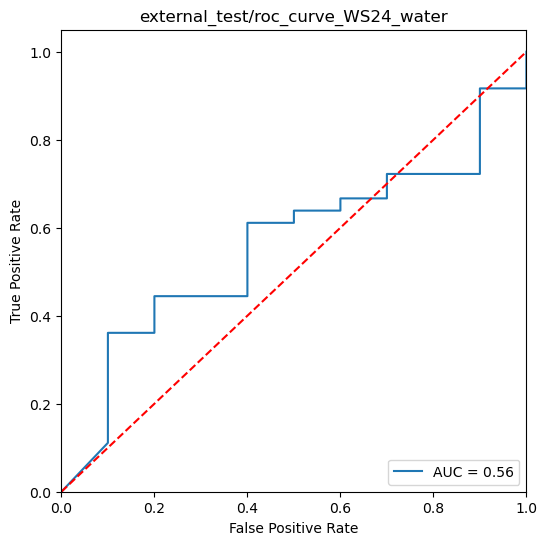

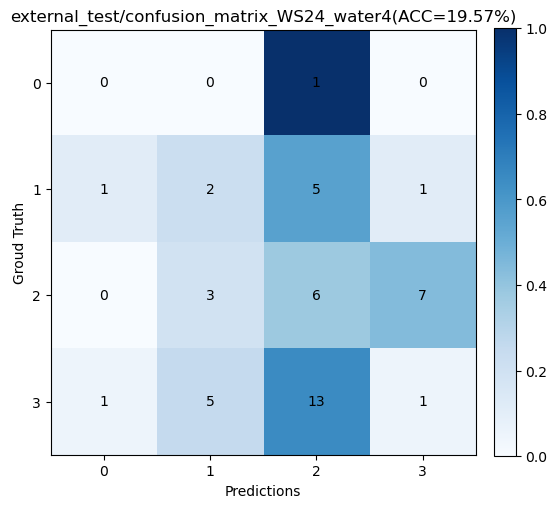

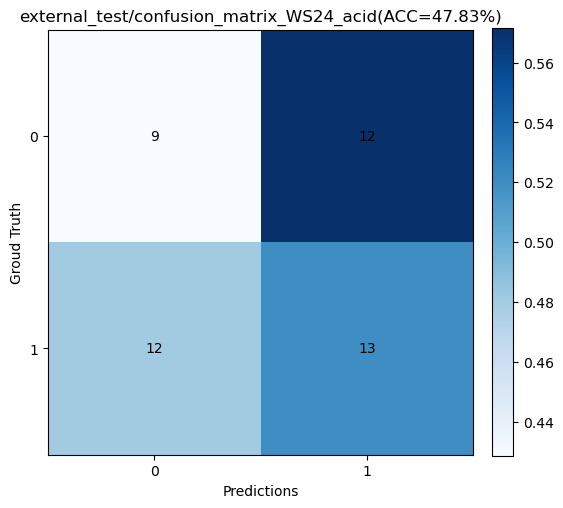

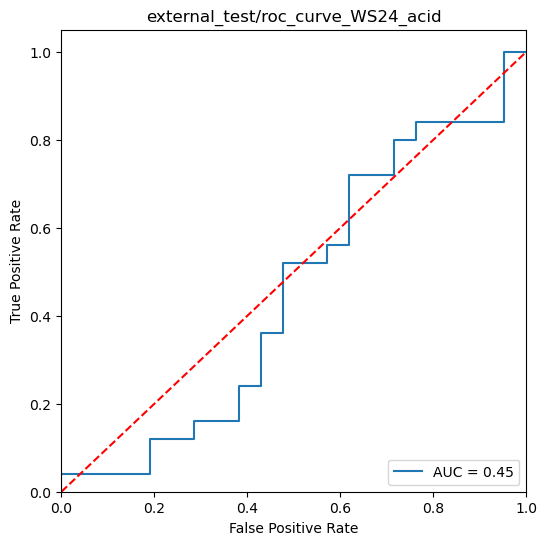

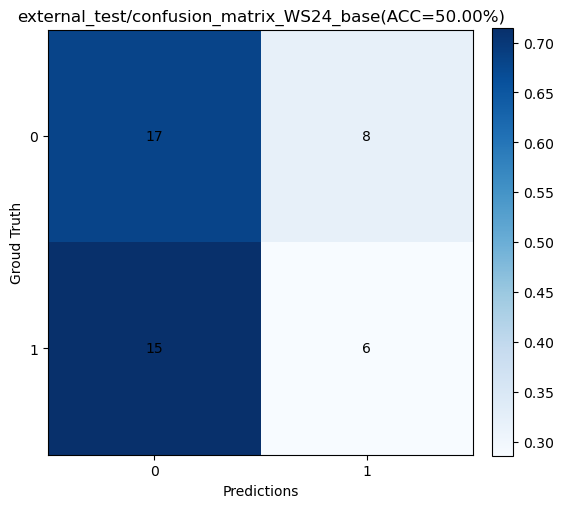

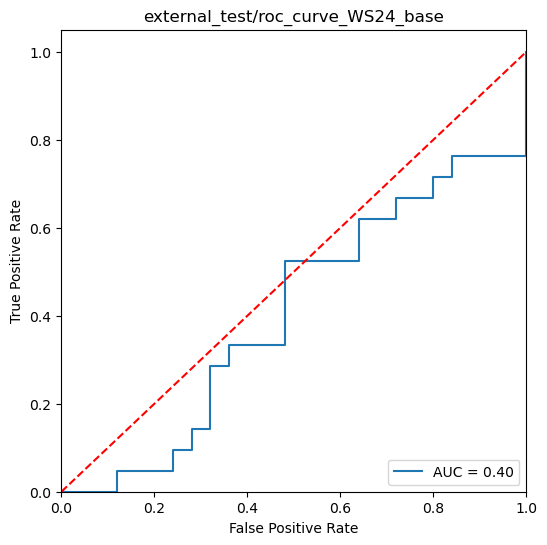

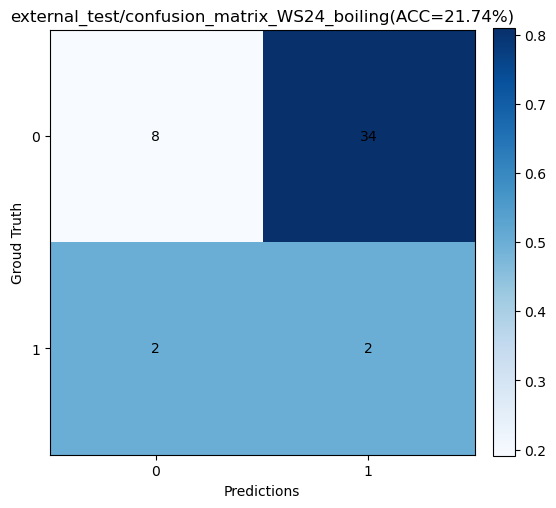

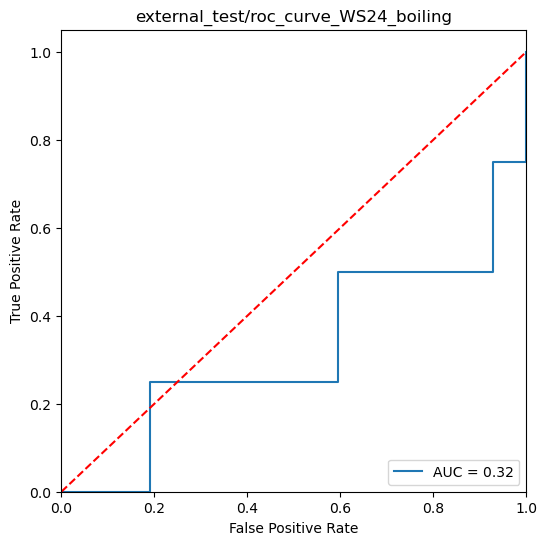

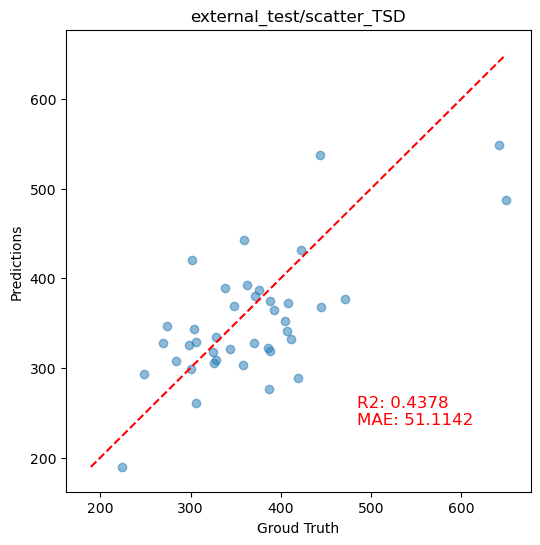

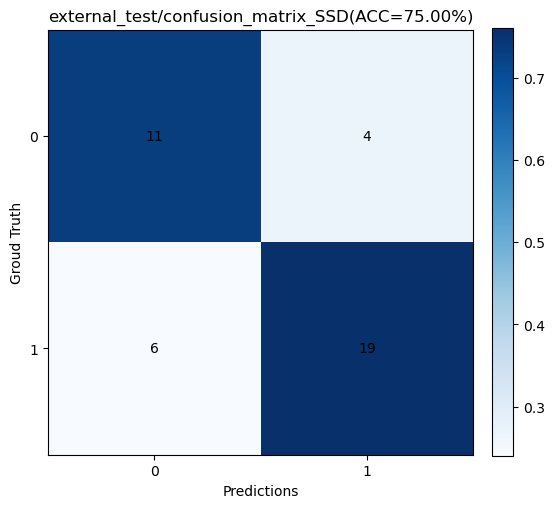

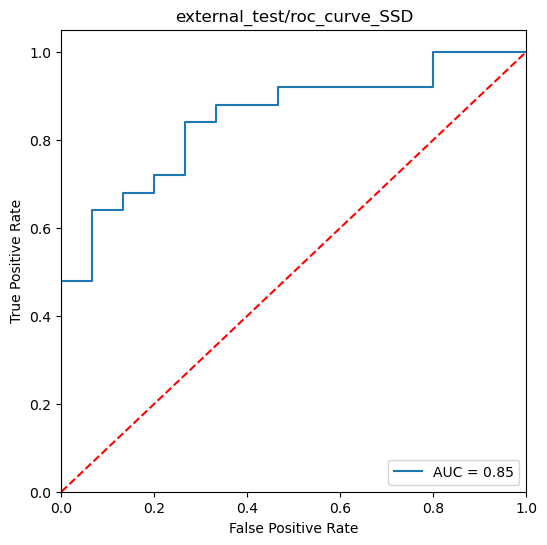

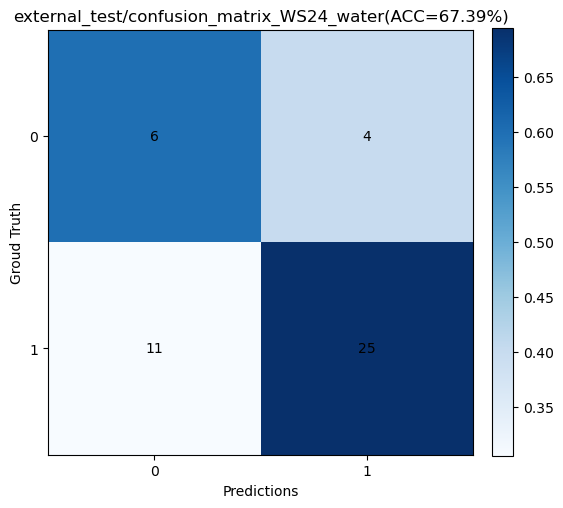

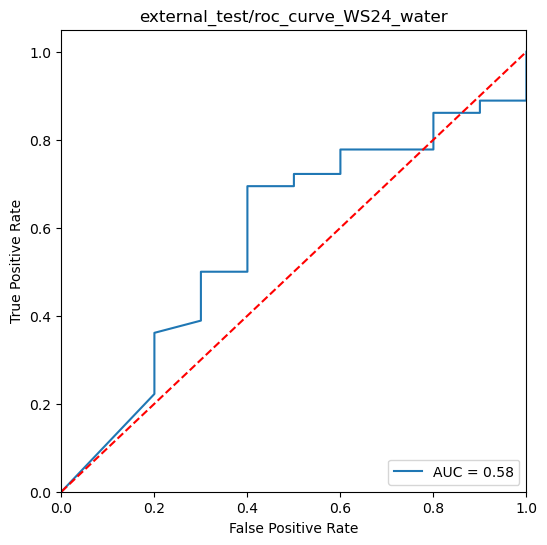

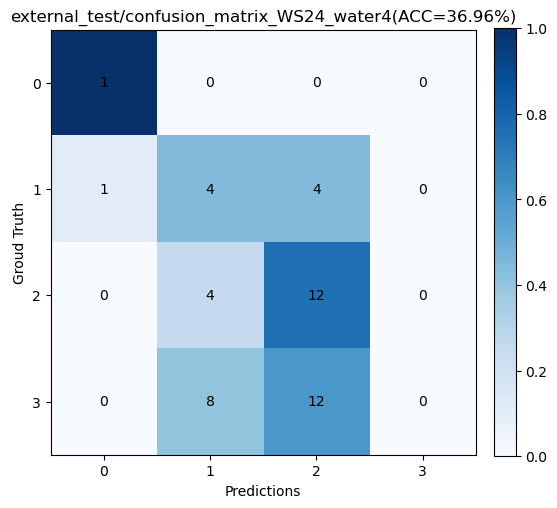

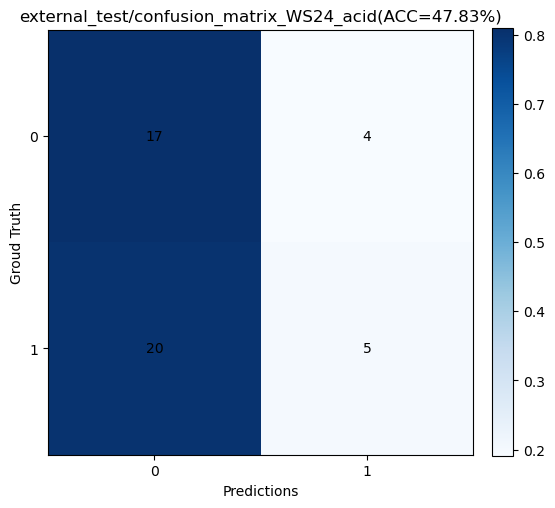

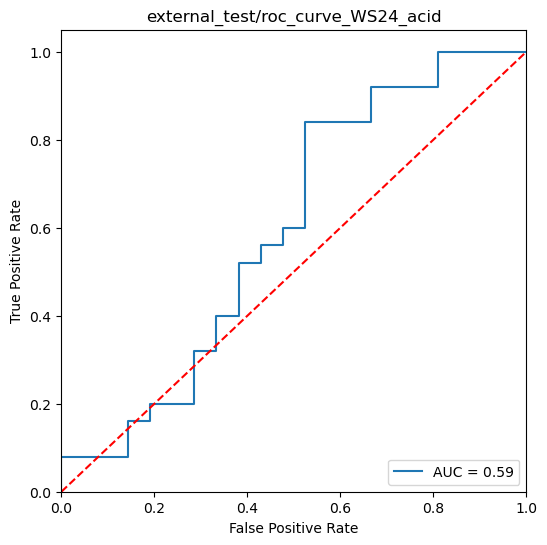

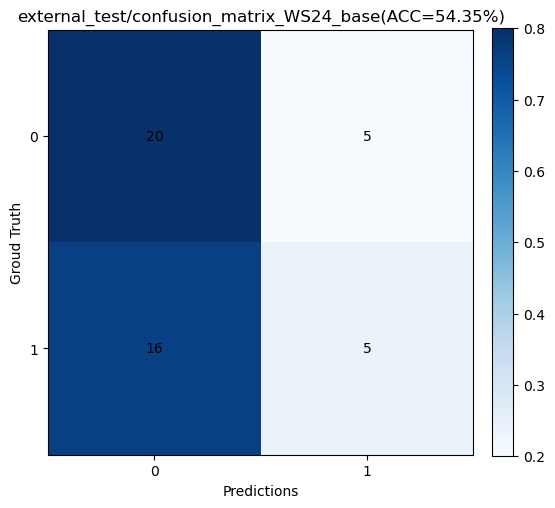

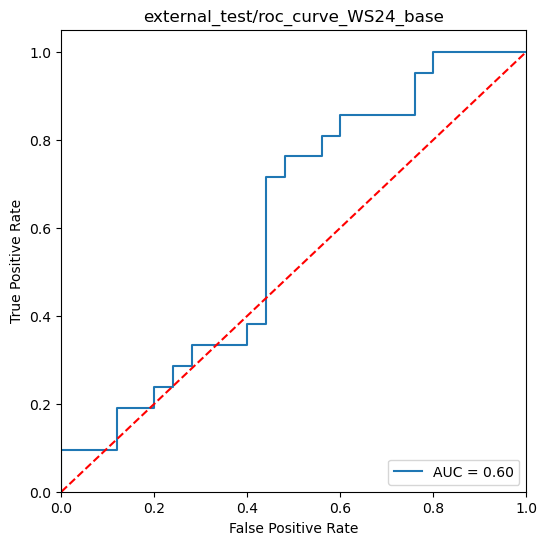

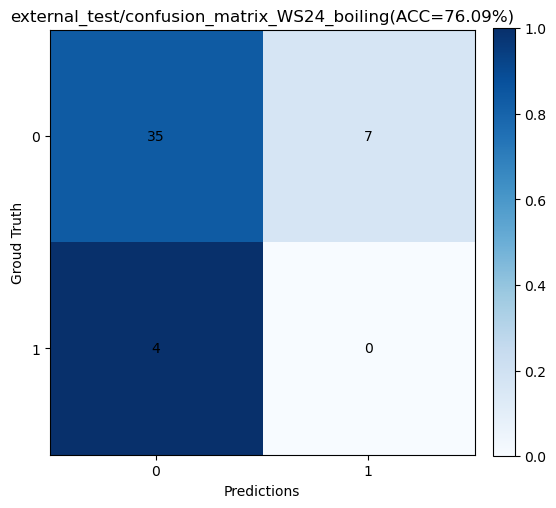

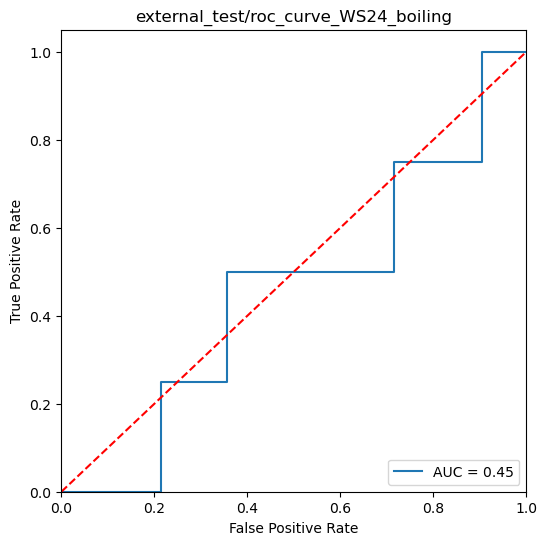

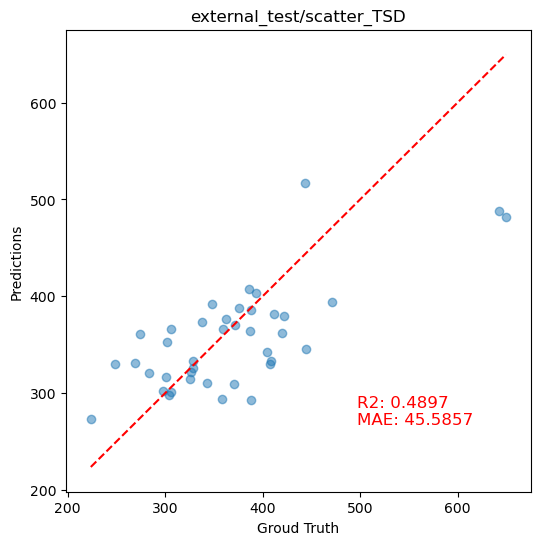

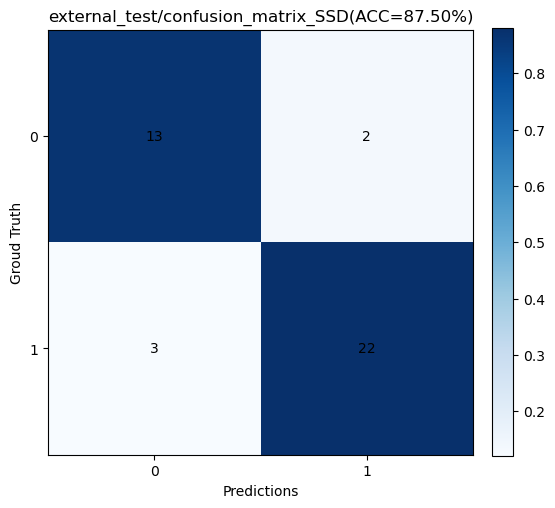

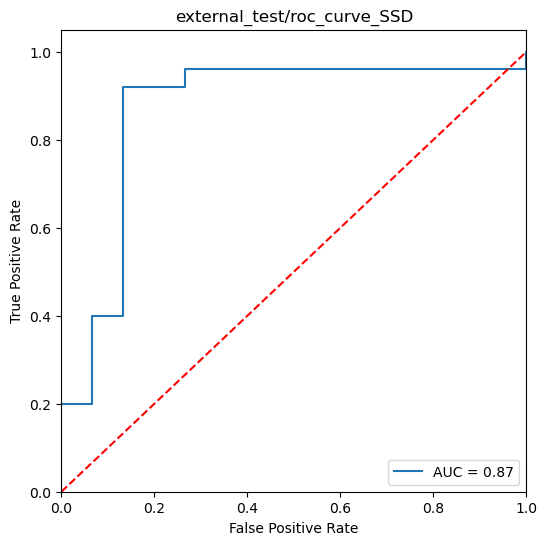

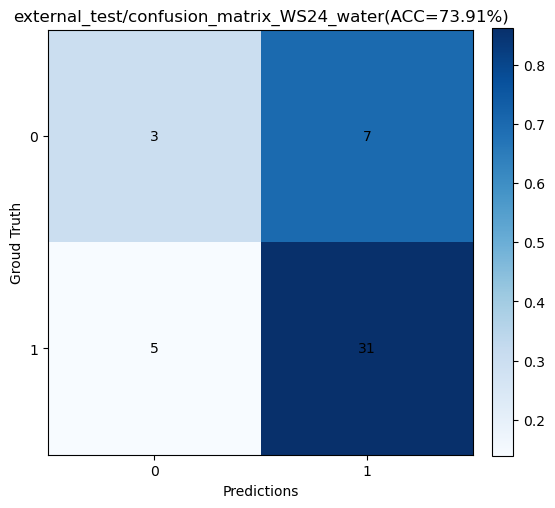

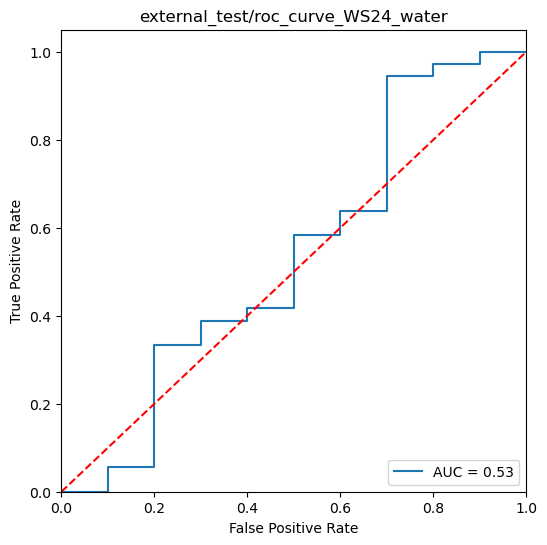

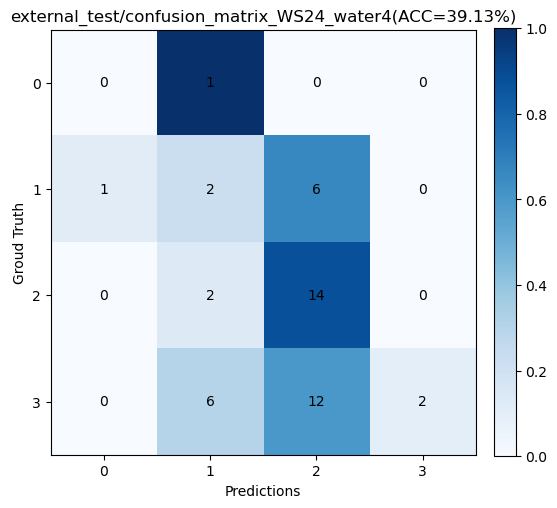

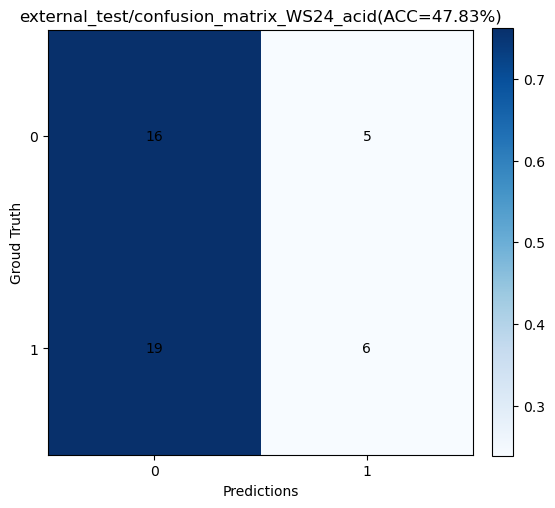

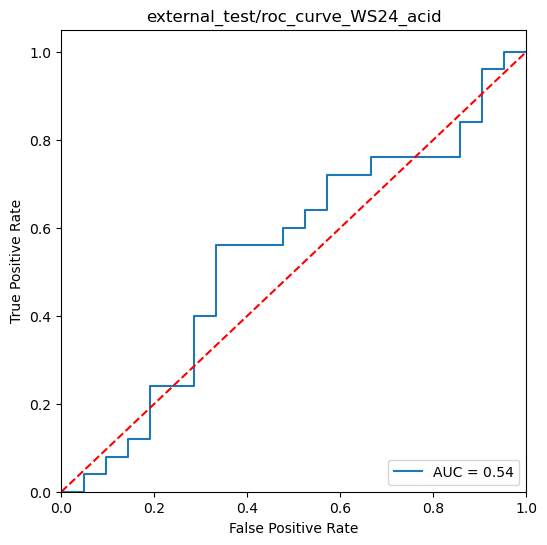

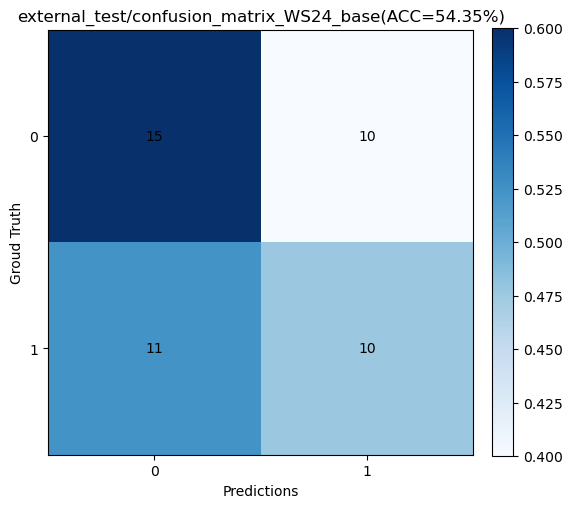

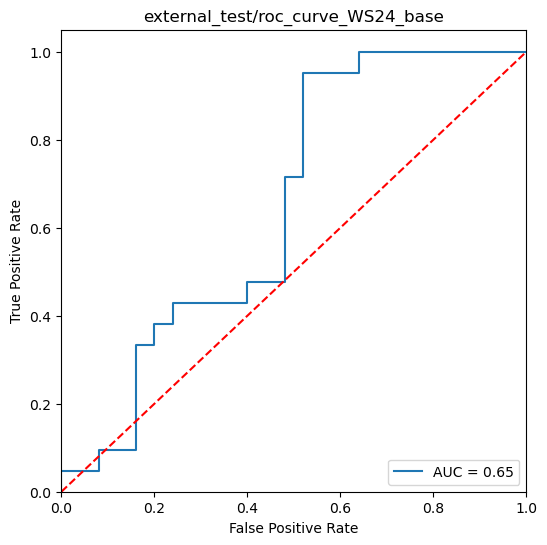

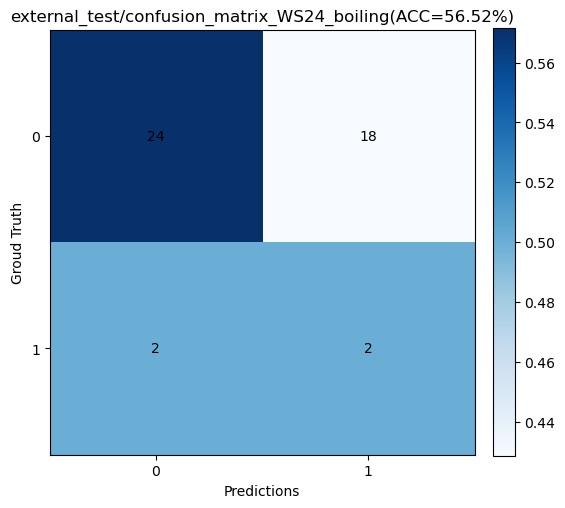

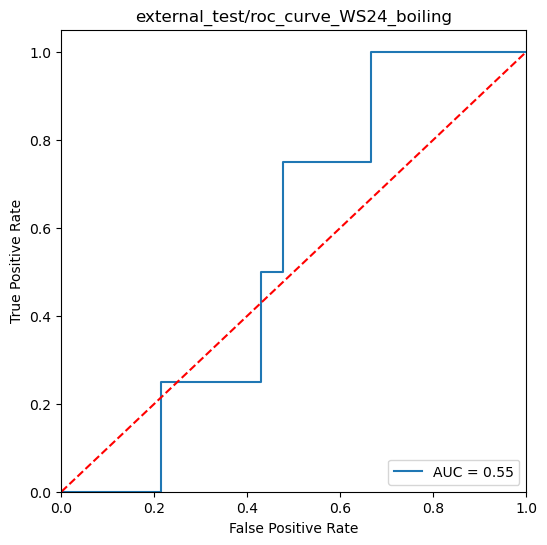

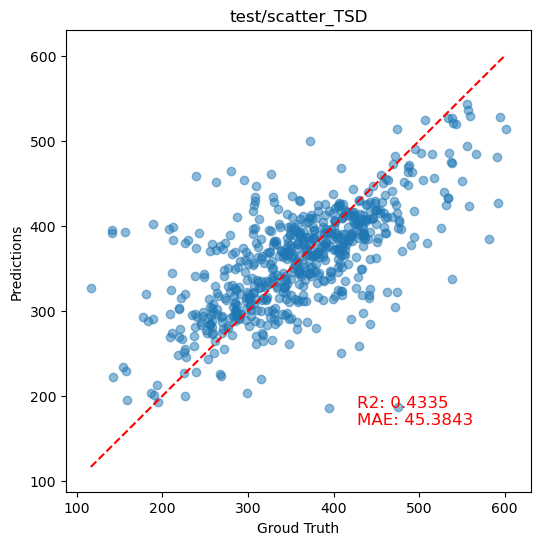

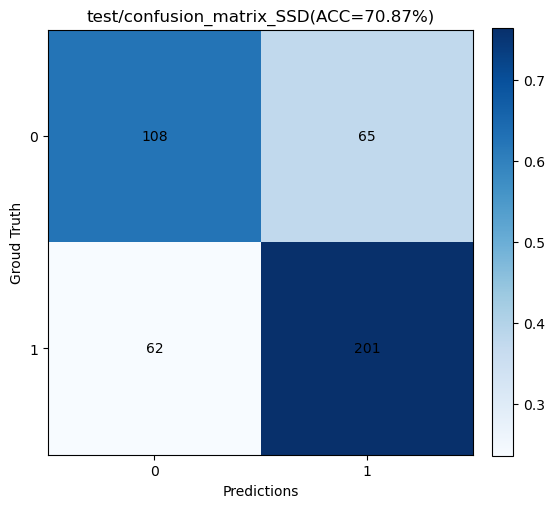

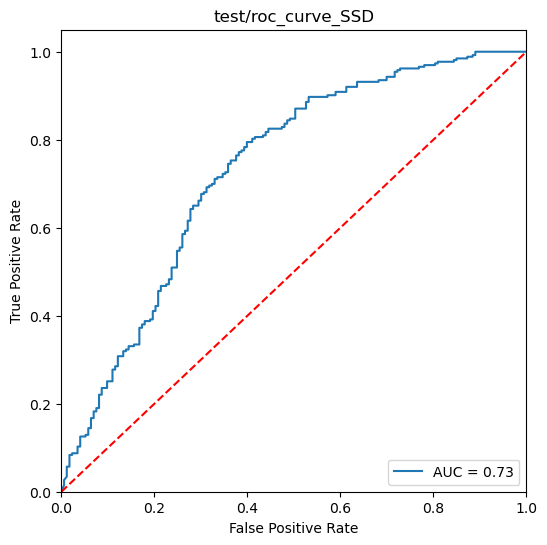

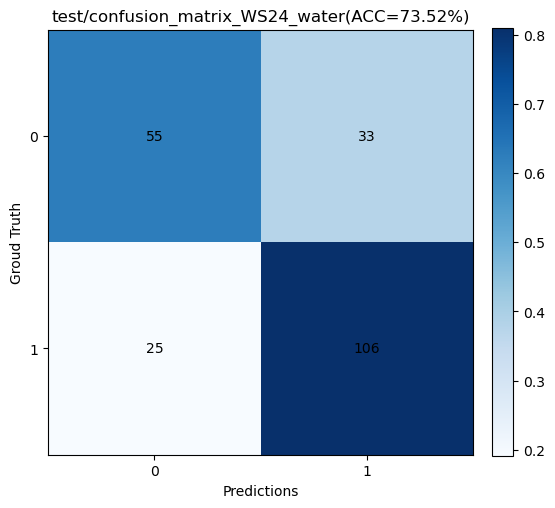

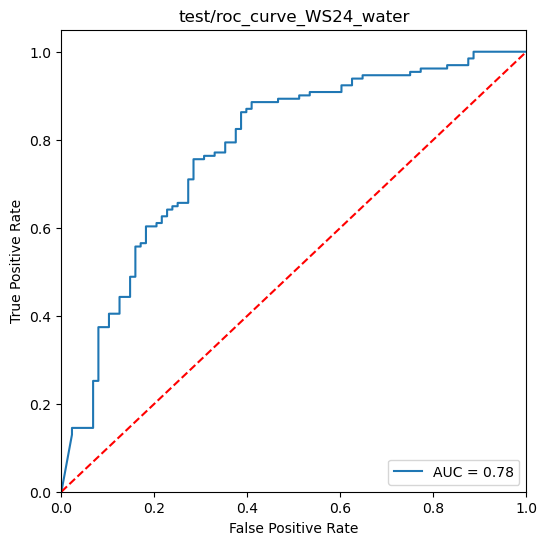

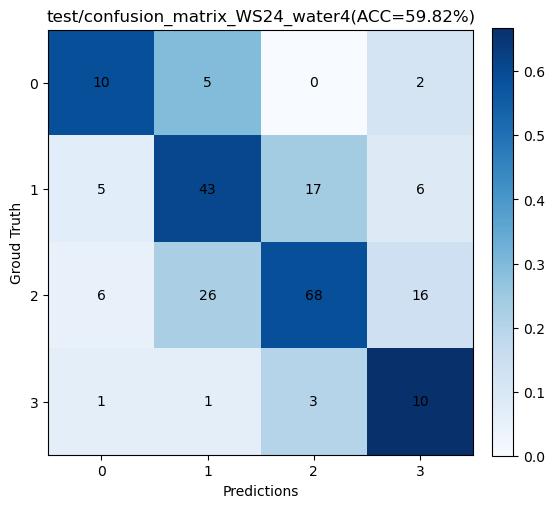

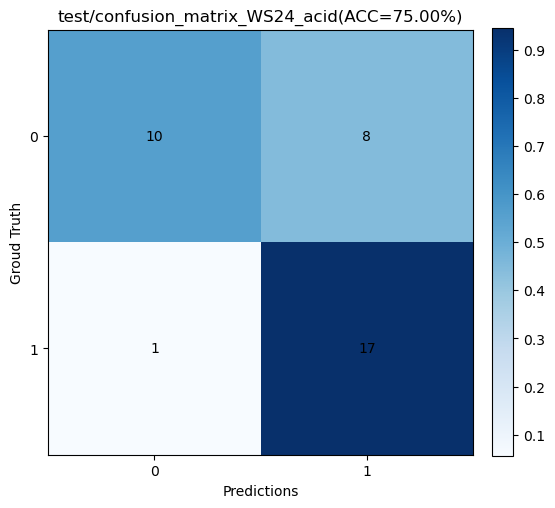

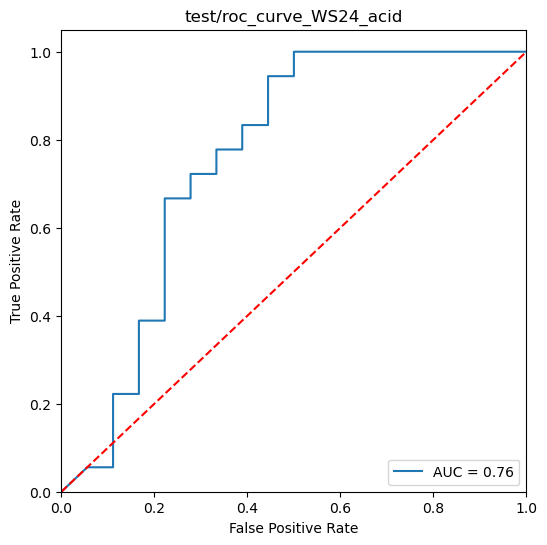

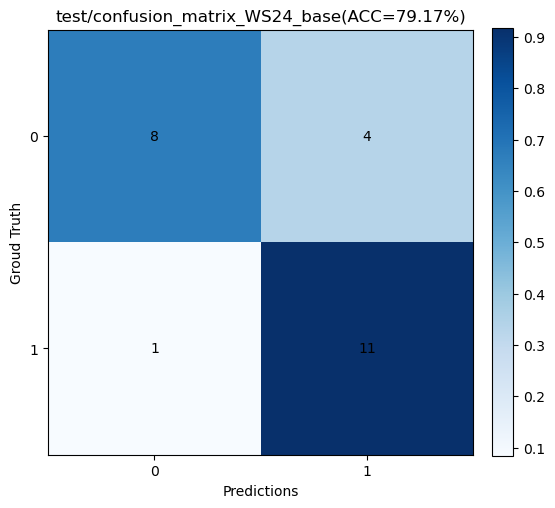

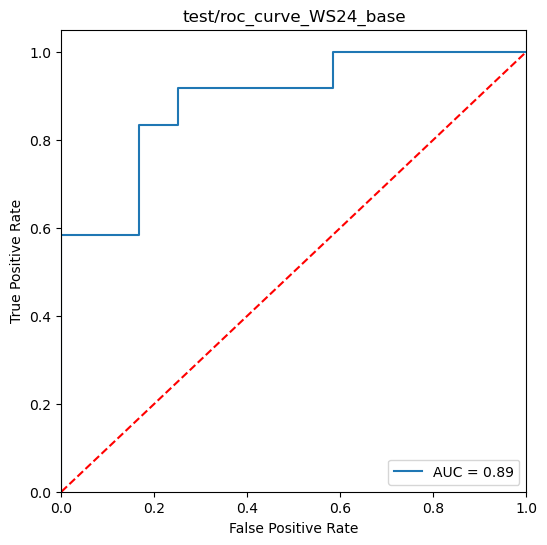

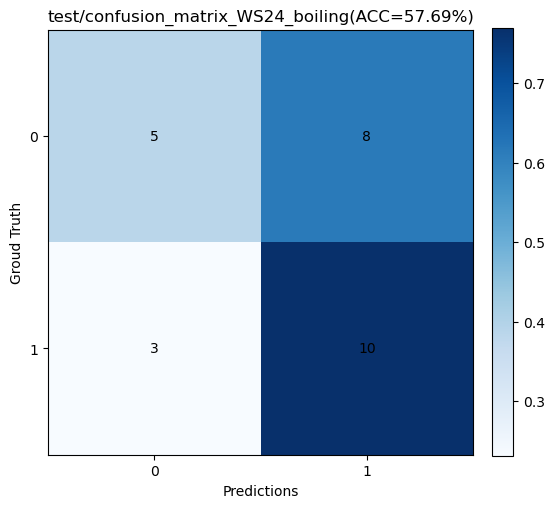

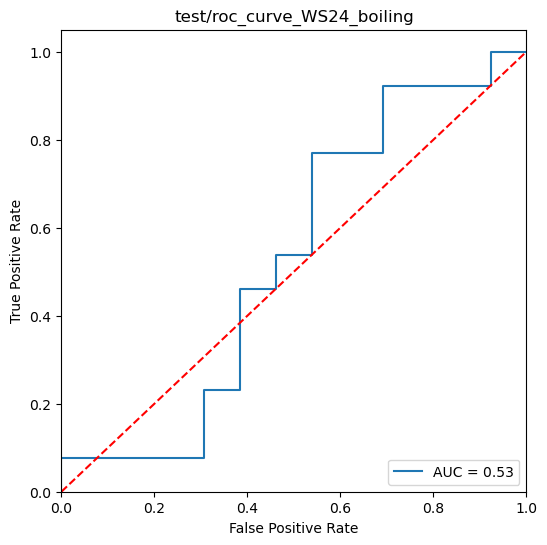

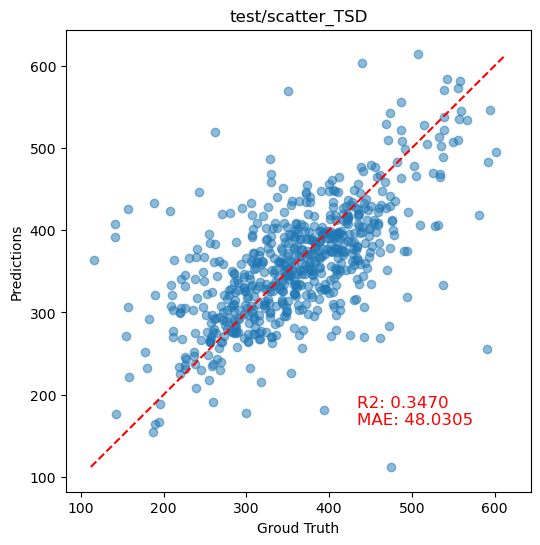

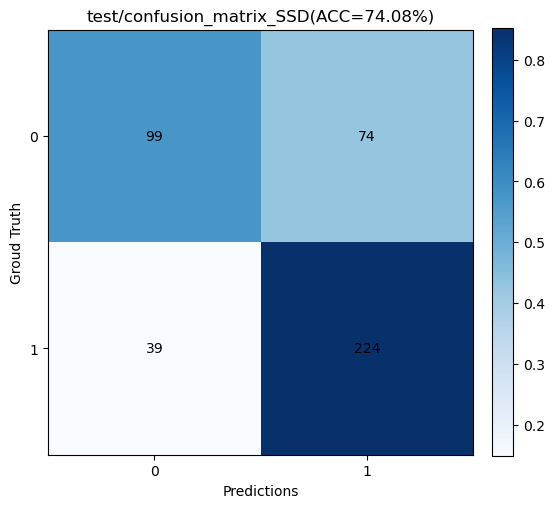

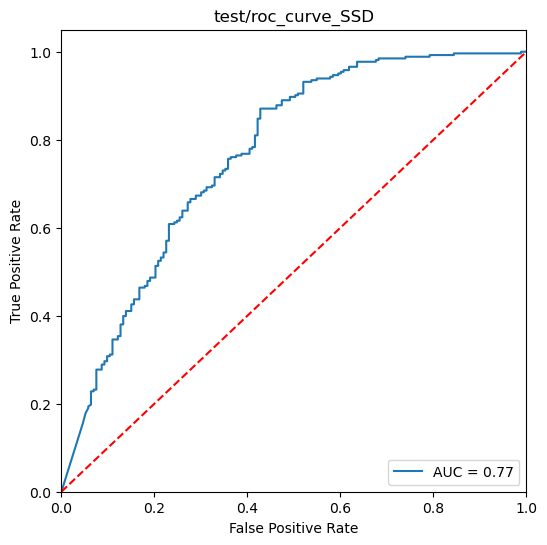

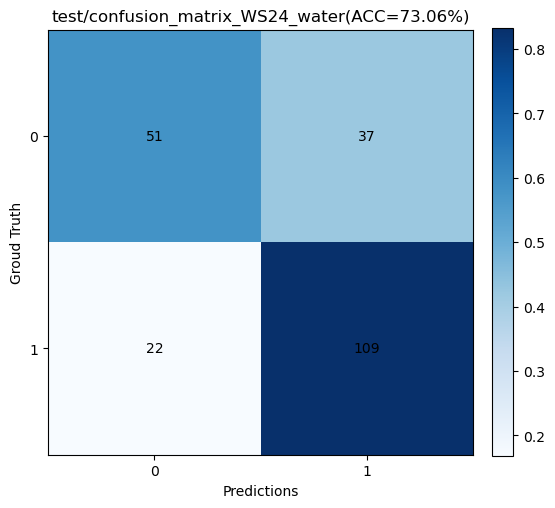

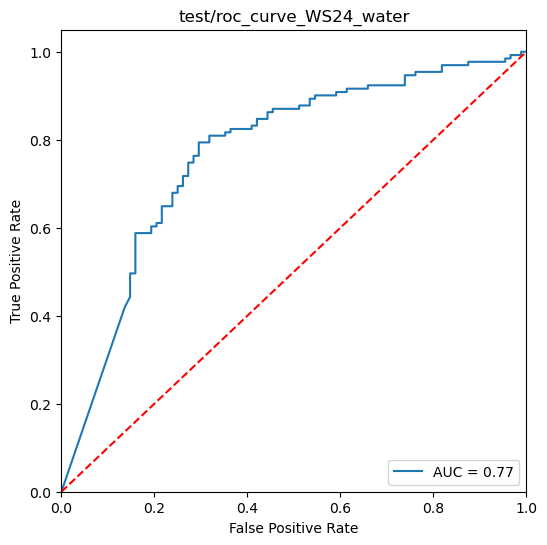

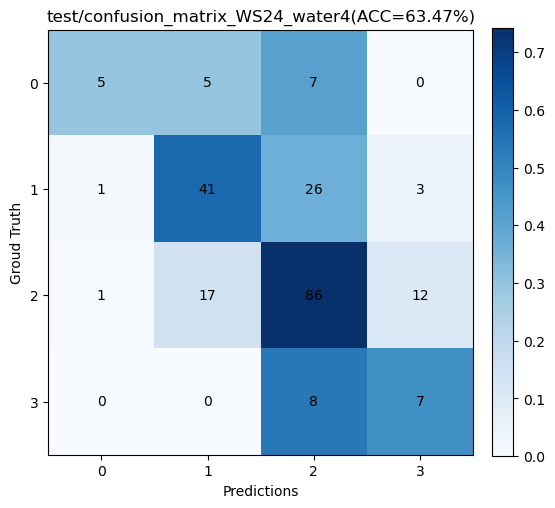

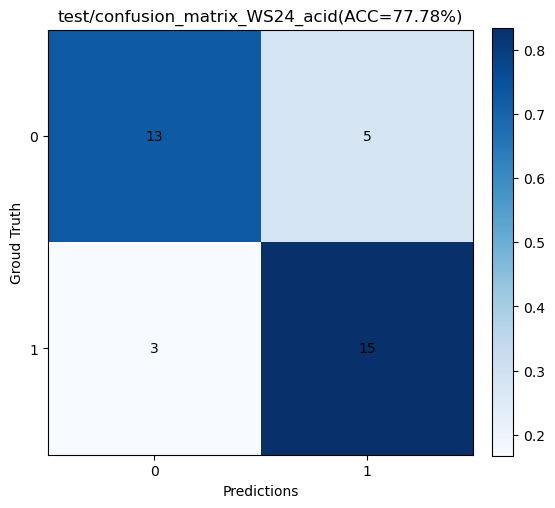

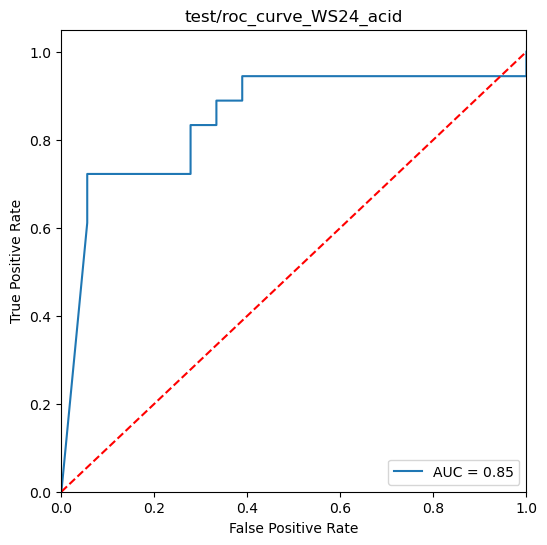

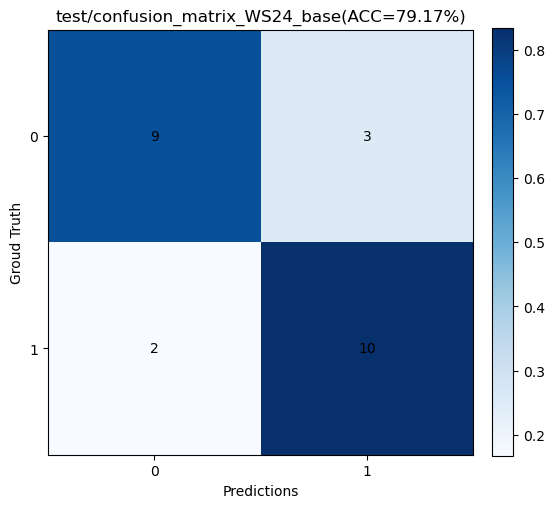

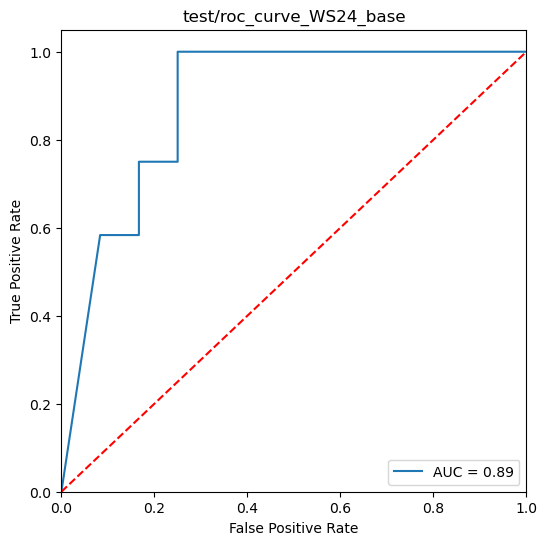

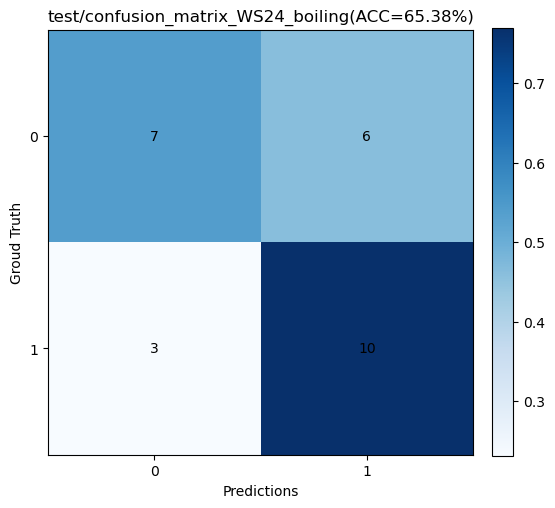

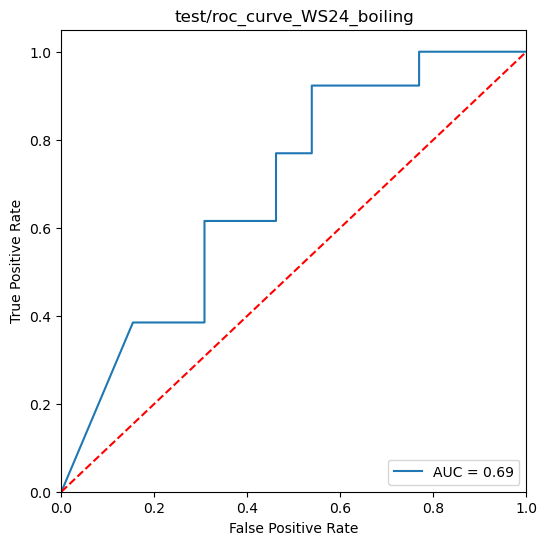

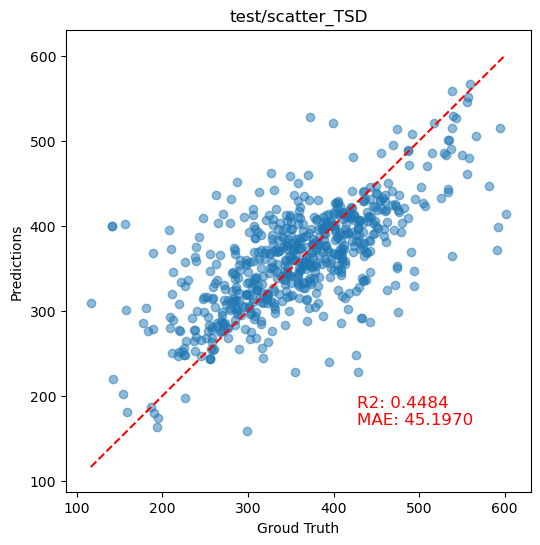

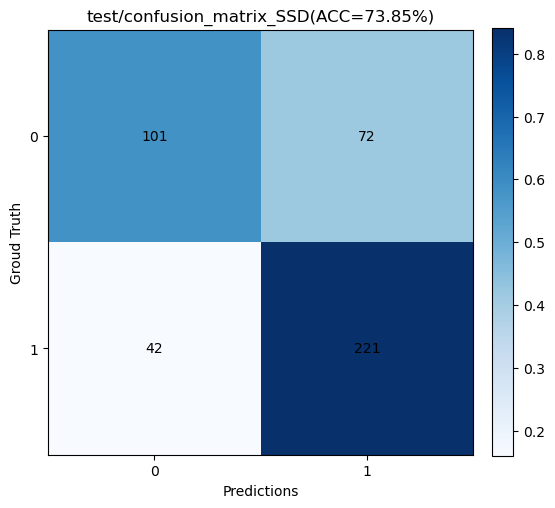

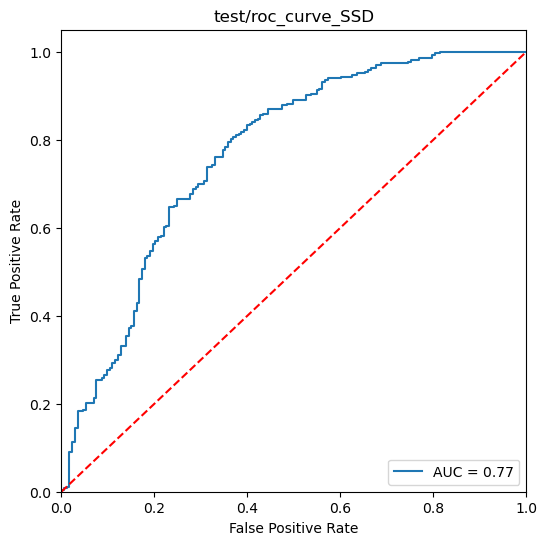

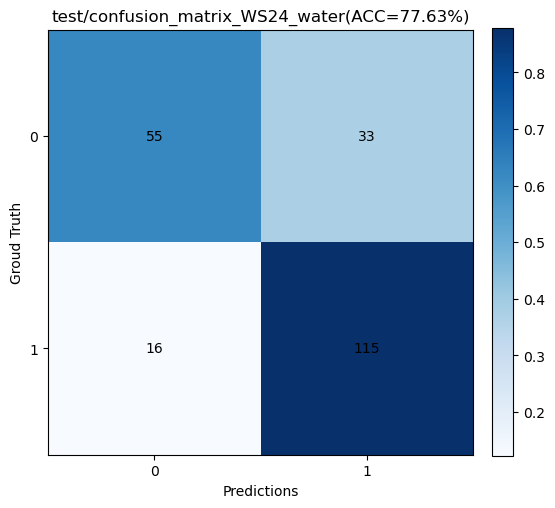

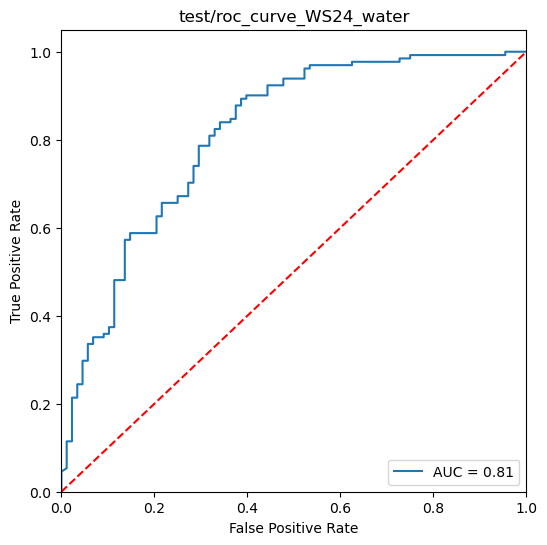

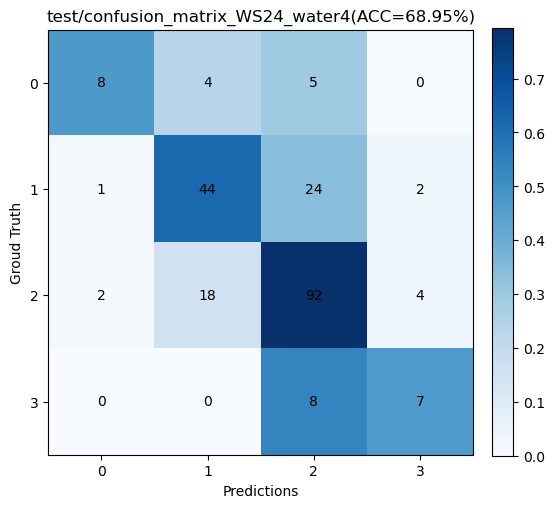

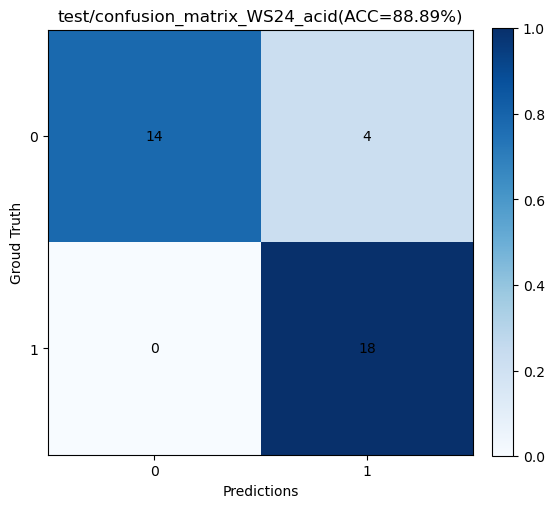

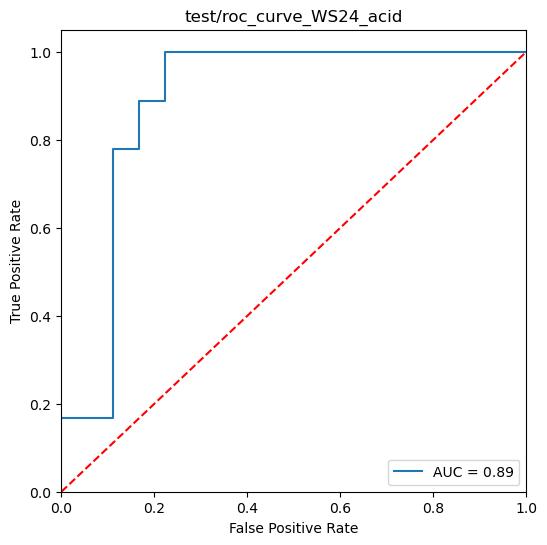

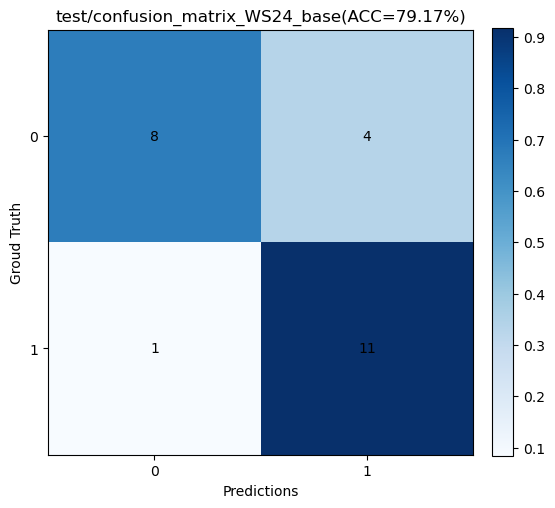

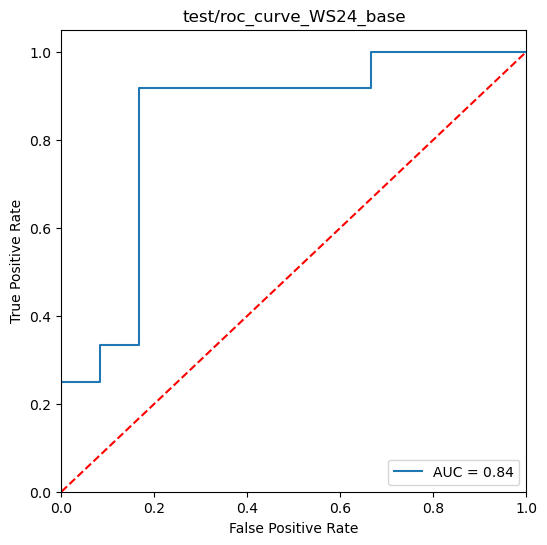

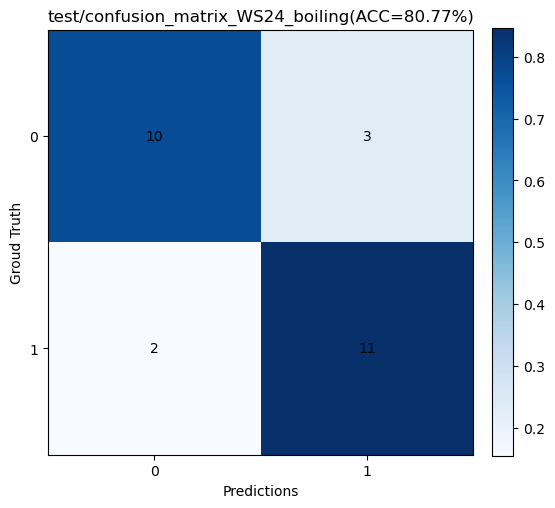

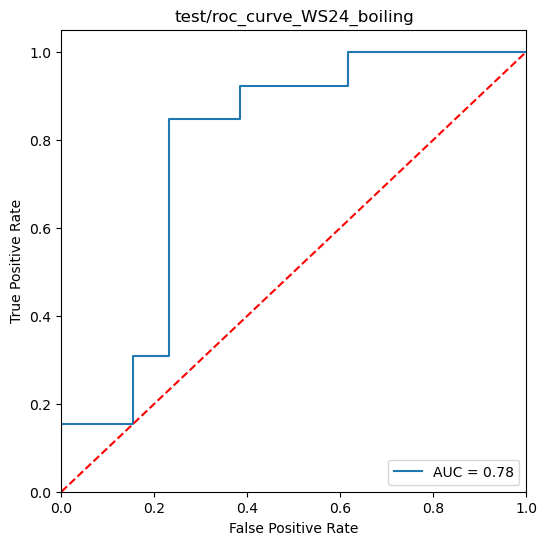

In [29]:

res = {}
result_dir = Path("./CGCNN_MT/evaluation")
data_dirs = [
    "./CGCNN_MT/data/TS_external_test",
    "./CGCNN_MT/data/WS24v2_external_test", 
]
col2tasks = [
    {"ts_label": "TSD", "ss_label": "SSD"},
    {"water_label": "WS24_water", "water4_label": "WS24_water4", "acid_label": "WS24_acid", "base_label": "WS24_base", "boiling_label": "WS24_boiling"}
    ]

tasks = [
    "TSD", 
    "SSD",
    "WS24_water",
    "WS24_water4",
    "WS24_acid",
    "WS24_base",
    "WS24_boiling",
    "TSD_SSD_WS24_all",
    "TSD_SSD_WS24_all_attn"
]
model_dirs = [task2models[t] for t in tasks]

split = "external_test"
metric_collections = []
for task in tasks:
    model_dir = task2models[task]["Path"]
    if task in ["TSD_SSD_WS24_all"]:
        model_name = task2models[task]["Model"] + "_multi"
    elif task in ["TSD_SSD_WS24_all_attn"]:
        model_name = "MOFSNN"
    else:
        model_name = task2models[task]["Model"] + "_single"
    version_name = Path(model_dir).name
    for col2task, data_dir in zip(col2tasks, data_dirs):
        all_outputs, all_metrics = predict_main(model_dir, data_dir, col2task, split=split, result_dir=result_dir)
        if all_metrics:
            all_metrics = {k.replace(f"{split}_", "") : v for k,v in all_metrics.items()}
            all_metrics.update({"Model": model_name, "Version": version_name, "Split": split})
            metric_collections.append(all_metrics)

data_dirs = [
    "./CGCNN_MT/data/TSD",
    "./CGCNN_MT/data/SSD", 
    "./CGCNN_MT/data/WS24",
]
col2tasks = [
    {"Label": "TSD"},
    {"Label": "SSD"},
    {"water_label": "WS24_water", "water4_label": "WS24_water4", "acid_label": "WS24_acid", "base_label": "WS24_base", "boiling_label": "WS24_boiling"},
    ]
for task in tasks:
    model_dir = task2models[task]["Path"]
    if task in ["TSD_SSD_WS24_all"]:
        model_name = task2models[task]["Model"] + "_multi"
    elif task in ["TSD_SSD_WS24_all_attn"]:
        model_name = "MOFSNN"
    else:
        model_name = task2models[task]["Model"] + "_single"
    version_name = Path(model_dir).name
    for col2task, data_dir in zip(col2tasks, data_dirs):
        for split in ["test"]:
            all_outputs, all_metrics = predict_main(model_dir, data_dir, col2task, split=split, result_dir=result_dir)
            if all_metrics:
                all_metrics = {k.replace(f"{split}_", "") : v for k,v in all_metrics.items()}
                all_metrics.update({"Model": model_name, "Version": version_name, "Split": split})
                metric_collections.append(all_metrics)
# pd.DataFrame(res).T.to_csv(result_dir/"all_metrics.csv")

In [33]:
metric_collections

[{'TSD/R2Score': 0.41370295081955355,
  'TSD/MeanAbsoluteError': 49.990334,
  'Model': 'cgcnn_raw_single',
  'Version': 'version_29',
  'Split': 'external_test'},
 {'SSD/Accuracy': 0.8,
  'SSD/BalancedAccuracy': 0.8266666666666667,
  'SSD/F1Score': 0.797979797979798,
  'SSD/MatthewsCorrCoef': 0.6333794997024097,
  'SSD/AUROC': 0.9600000000000001,
  'Model': 'cgcnn_raw_single',
  'Version': 'version_4',
  'Split': 'external_test'},
 {'WS24_water/Accuracy': 0.5869565217391305,
  'WS24_water/BalancedAccuracy': 0.4111111111111111,
  'WS24_water/F1Score': 0.4138162307176392,
  'WS24_water/MatthewsCorrCoef': -0.17190889899208114,
  'WS24_water/AUROC': 0.5583333333333333,
  'Model': 'cgcnn_raw_single',
  'Version': 'version_29',
  'Split': 'external_test'},
 {'WS24_water4/Accuracy': 0.1956521739130435,
  'WS24_water4/BalancedAccuracy': 0.16180555555555556,
  'WS24_water4/F1Score': 0.14304368996503034,
  'WS24_water4/MatthewsCorrCoef': -0.19231958302221358,
  'WS24_water4/AUROC': 0.34976851851

In [37]:
reversed_dict = {}
tasks = [
    "TSD", 
    "SSD",
    "WS24_water",
    "WS24_water4",
    "WS24_acid",
    "WS24_base",
    "WS24_boiling",]
for metric_d in metric_collections:
    model = metric_d["Model"]
    version = metric_d["Version"]
    split = metric_d["Split"]
    for metric_name, metric_value in metric_d.items():
        if metric_name in ["Model", "Version", "Split"]:
            continue
        task_name, metric_name = metric_name.split("/")
        if (task_name, model, version, split) not in reversed_dict:
            reversed_dict[(task_name, model, version, split)] = {metric_name: metric_value}
        else:
            reversed_dict[(task_name, model, version, split)][metric_name] = metric_value
records = []
for k, v in reversed_dict.items():
    task_name, model, version, split = k
    v.update({"Model": model, "Version": version, "Split": split, "Task": task_name})
    records.append(v)
df_res = pd.DataFrame(records)
model_map = {
    "cgcnn_raw_multi": "CGCNN_MT",
    "cgcnn_raw_single": "CGCNN_SG",
    "MOFSNN": "MOFSNN",
    
}
metric_name_map = {
    "R2Score": "R2",
    "MeanAbsoluteError": "MAE",
    "Accuracy": "ACC",
    "BalancedAccuracy": "BACC",
    "F1Score": "F1",
    "MatthewsCorrCoef": "MCC",
}
df_res["Model"] = df_res["Model"].map(model_map).copy()
df_res.rename(columns=metric_name_map, inplace=True)
for split in df_res["Split"].unique():
    print("-"*100)
    print(f"Split: {split}")
    sub_df = df_res[df_res["Split"] == split].copy()
    sub_df.set_index(["Task", "Model"], inplace=True)
    sub_df.sort_index(inplace=True)
    sub_df.drop(columns=["Split", "Version", "F1", "MCC"], inplace=True)
    sub_df.to_excel(saved_dir/f"CGCNN_results_{split}.xlsx")

    df_ml_metrics = pd.read_excel(saved_dir/f'ML_results_{split}.xlsx', index_col=[0,1])
    df_ml_cgcnn = pd.concat([sub_df, df_ml_metrics.loc[[(task, "ML_retrained") for task in tasks]]], axis=0)
    df_ml_cgcnn.sort_index(inplace=True)
    if "Algorithm" in df_ml_cgcnn.columns:
        df_ml_cgcnn.drop(columns=["Algorithm"], inplace=True)
    df_ml_cgcnn.to_excel(saved_dir/f"CGCNN_ML_results_{split}.xlsx")
    print(df_ml_cgcnn)

----------------------------------------------------------------------------------------------------
Split: external_test
                                 R2        MAE       ACC      BACC     AUROC
Task         Model                                                          
SSD          CGCNN_MT           NaN        NaN  0.750000  0.746667  0.848000
             CGCNN_SG           NaN        NaN  0.800000  0.826667  0.960000
             ML_retrained       NaN        NaN  0.750000  0.760000  0.856000
             MOFSNN             NaN        NaN  0.875000  0.873333  0.866667
TSD          CGCNN_MT      0.437760  51.114208       NaN       NaN       NaN
             CGCNN_SG      0.413703  49.990334       NaN       NaN       NaN
             ML_retrained  0.349546  53.829348       NaN       NaN       NaN
             MOFSNN        0.489687  45.585678       NaN       NaN       NaN
WS24_acid    CGCNN_MT           NaN        NaN  0.478261  0.504762  0.594286
             CGCNN_SG          

## MOFSNN trained on subset of datasets

In [38]:
task2models = {'TSD_SSD_WS24_water_WS24_water4': {'Model': 'att_cgcnn',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_seed42_att_cgcnn/version_13'},
 'WS24_all': {'Model': 'att_cgcnn',
  'Path': './CGCNN_MT/logs/WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_34'},
 'TSD_SSD_WS24_all_attn': {'Model': 'att_cgcnn',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_43'}}

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


task_types:  ['regression', 'classification', 'classification', 'classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 64
extra_fea_len: 32
h_fea_len: 144
n_conv: 8
n_h: 10
att_S: 64
dropout_prob: 0.8
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
task_att_type: se

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4487, TSD/test_MeanAbsoluteError: 46.2416


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_seed42_att_cgcnn@version_13/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 64
extra_fea_len: 32
h_fea_len: 144
n_conv: 8
n_h: 10
att_S: 64
dropout_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_seed42_att_cgcnn@version_13/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 64
extra_fea_len: 32
h_fea_len: 144
n_conv: 8
n_h: 10
att_S: 64
dropout_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_seed42_att_cgcnn@version_13/test_metrics.csv
task_types:  ['classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 4
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 240
extra_fea_len: 28
h_fea_len: 128
n_conv: 9
n_h

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 4
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 240
extra_fea_len: 28
h_fea_len: 128
n_conv: 9
n_h: 9
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
task_att_type: self
data_dir: ./CGCNN_MT/data
dl_sampler: random
loss_aggregation: fixed_weight_sum
m

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_34/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fe

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4484, TSD/test_MeanAbsoluteError: 45.1970


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/zhangsd/repos/MOFSNN/CGCNN_MT/module/module_utils.py:150: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv


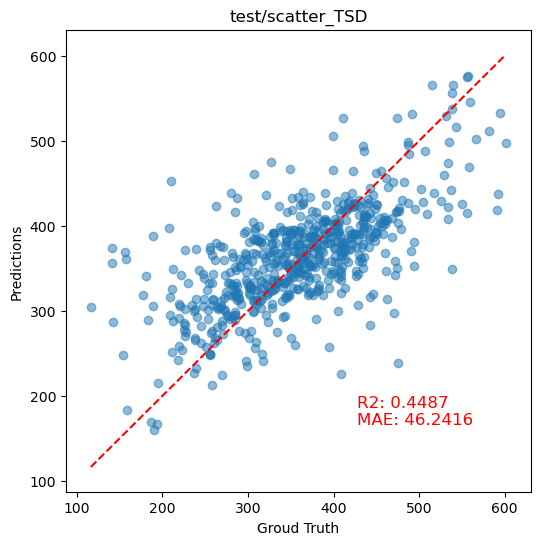

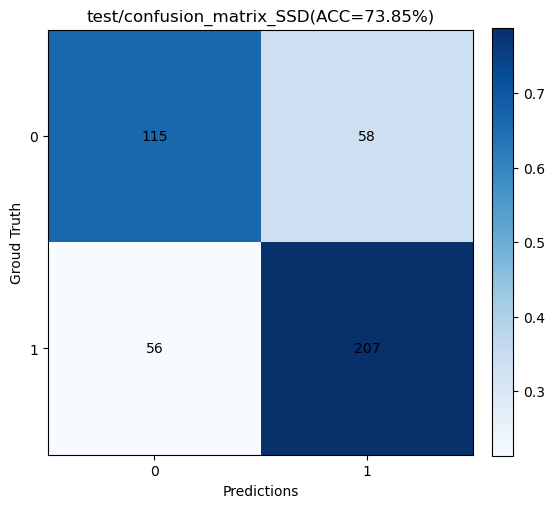

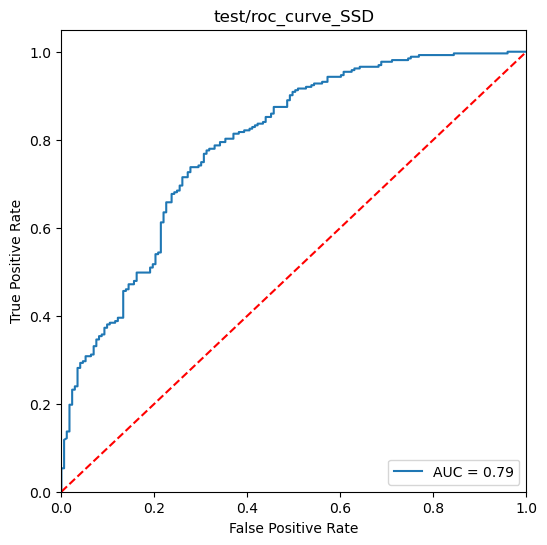

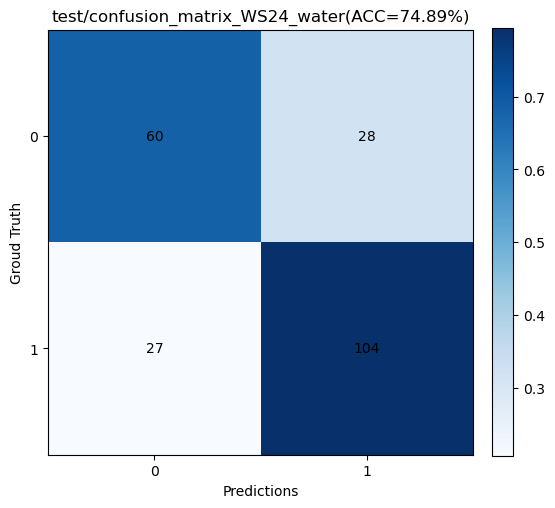

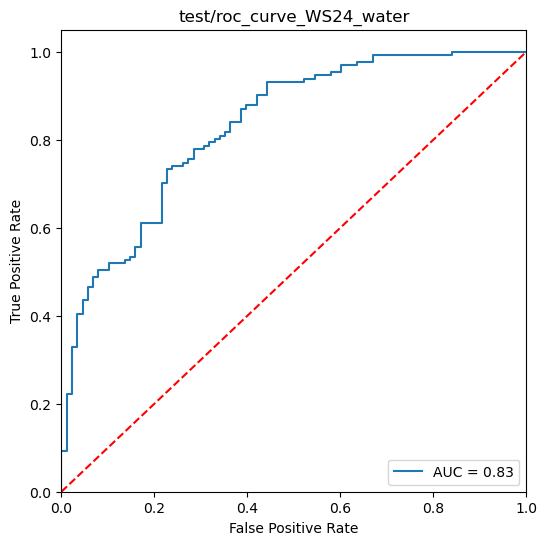

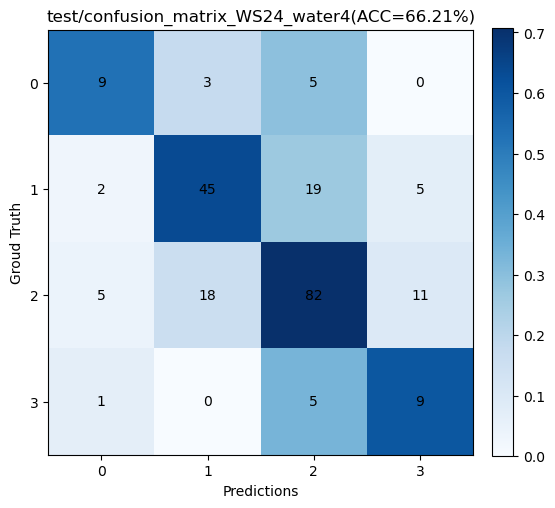

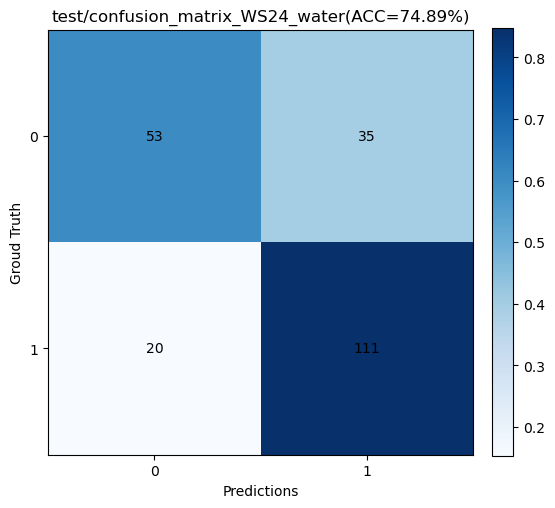

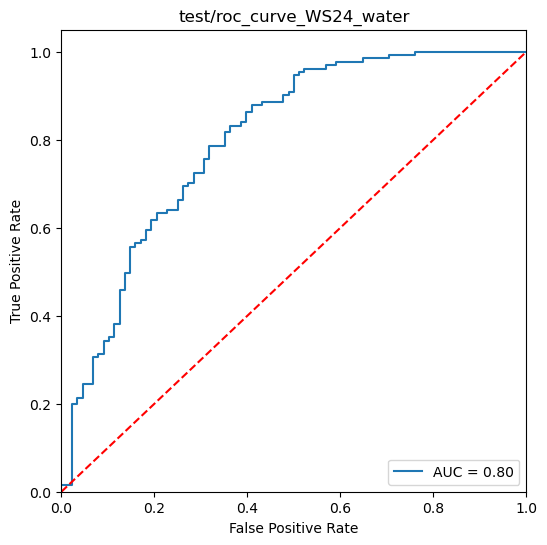

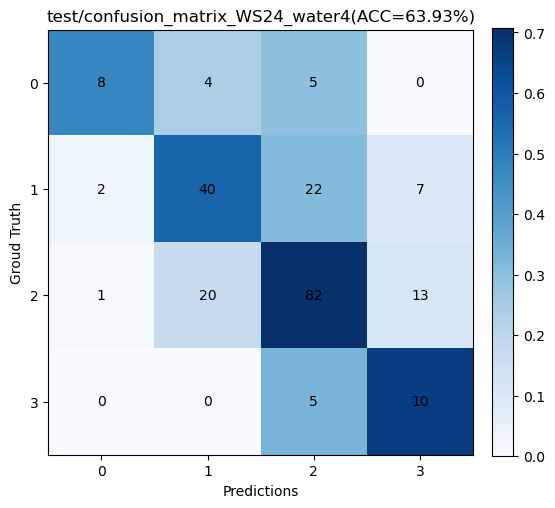

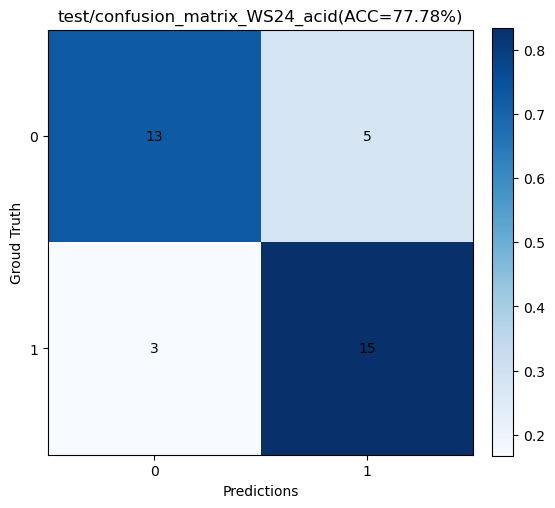

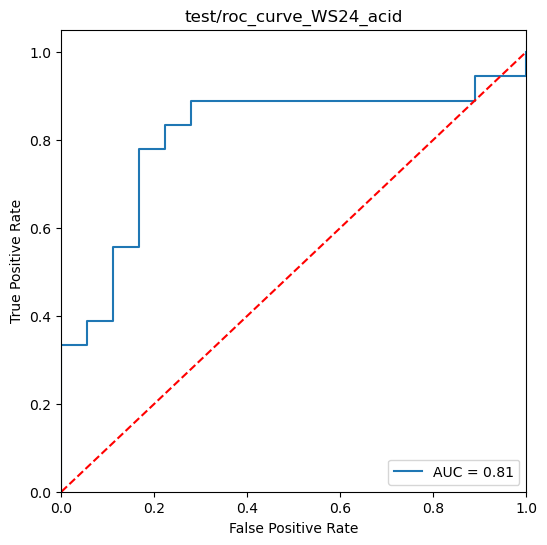

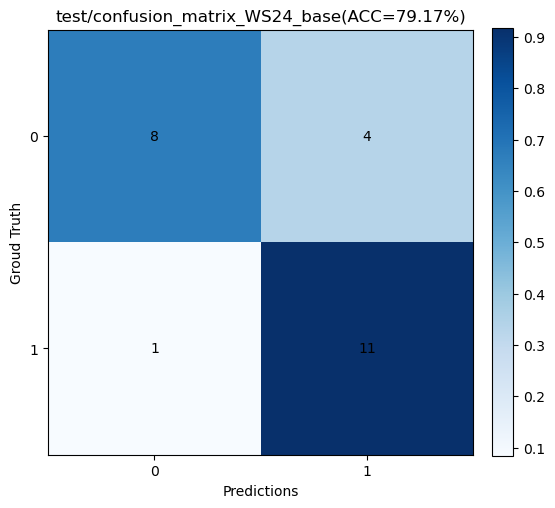

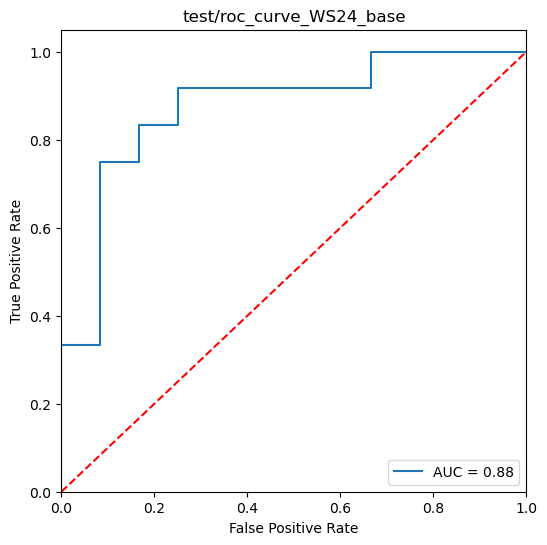

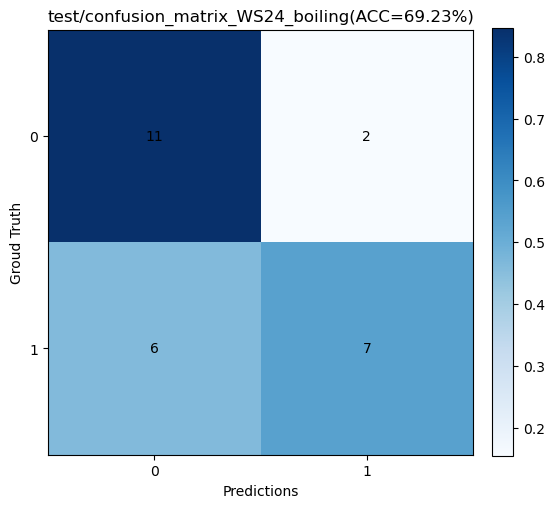

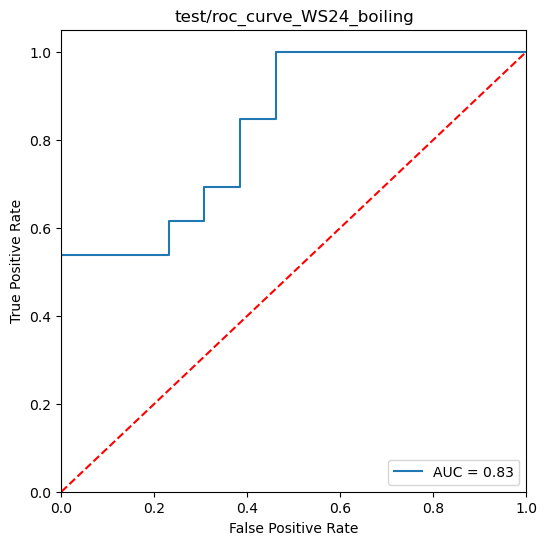

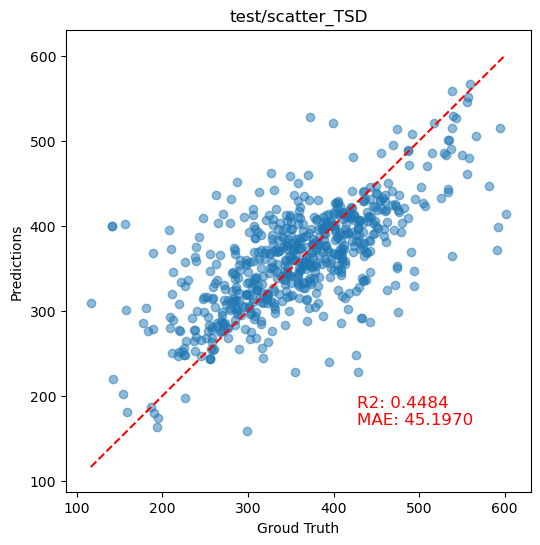

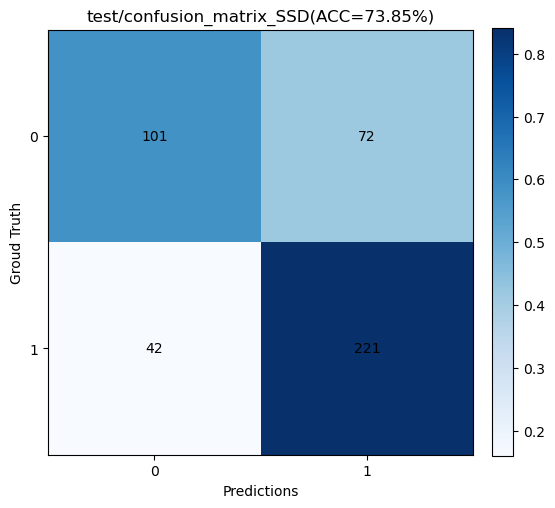

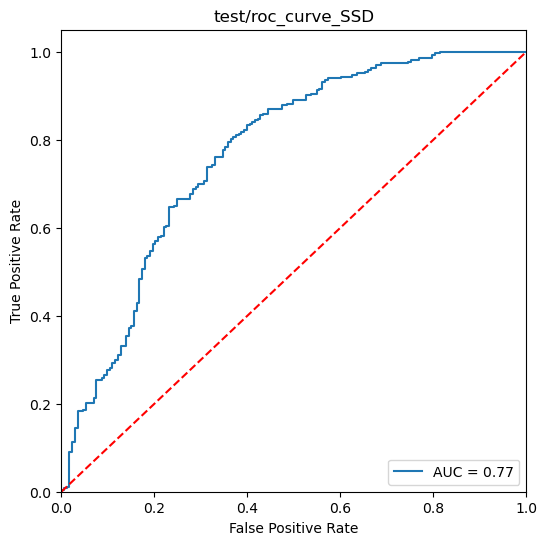

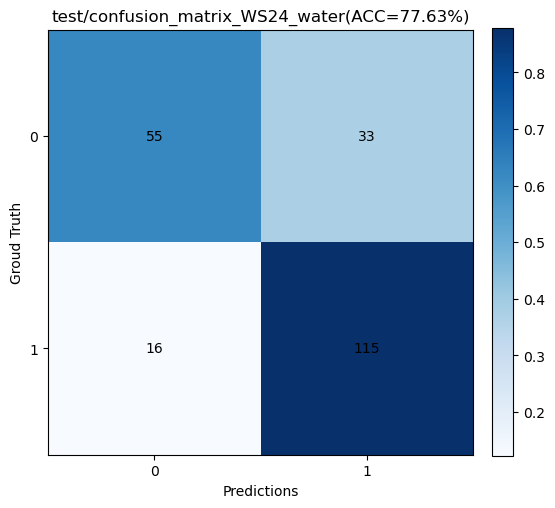

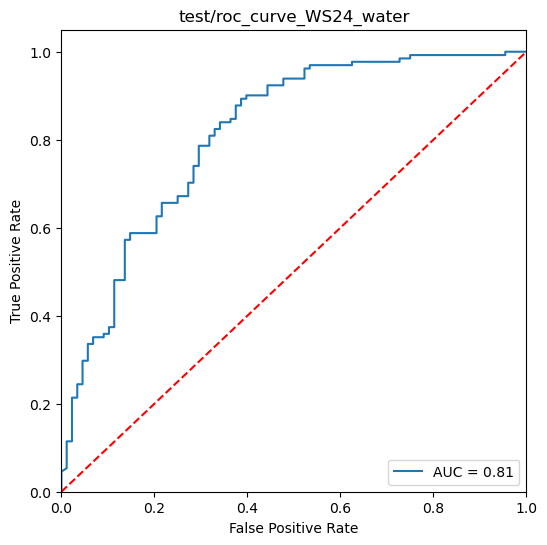

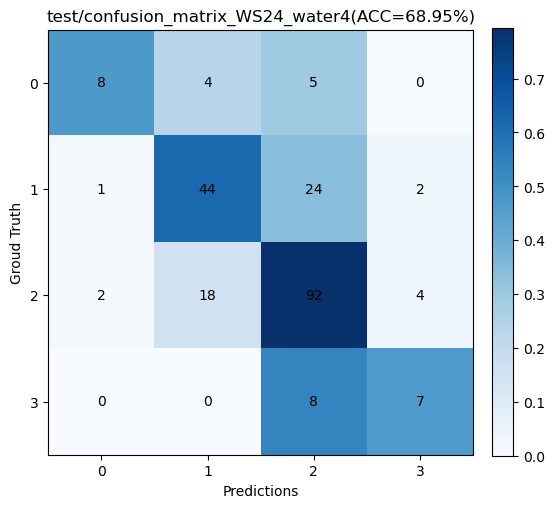

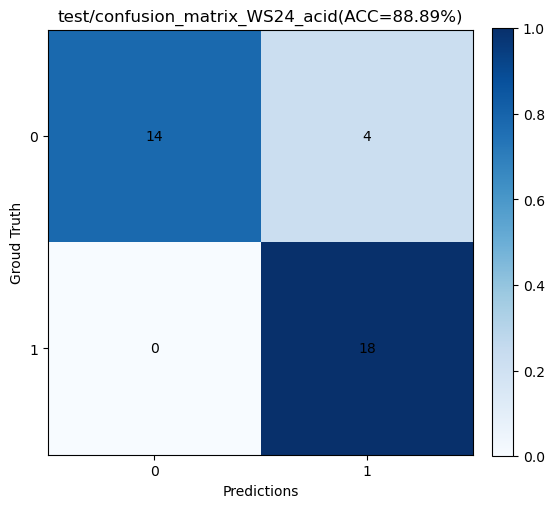

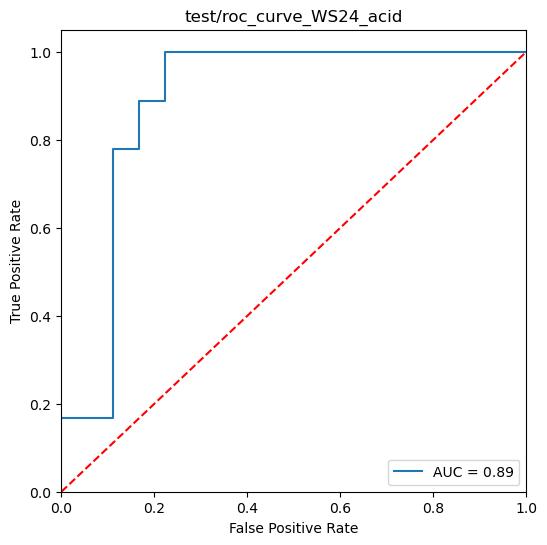

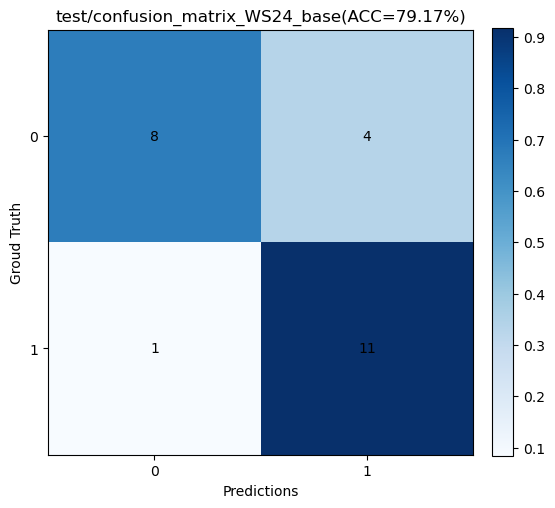

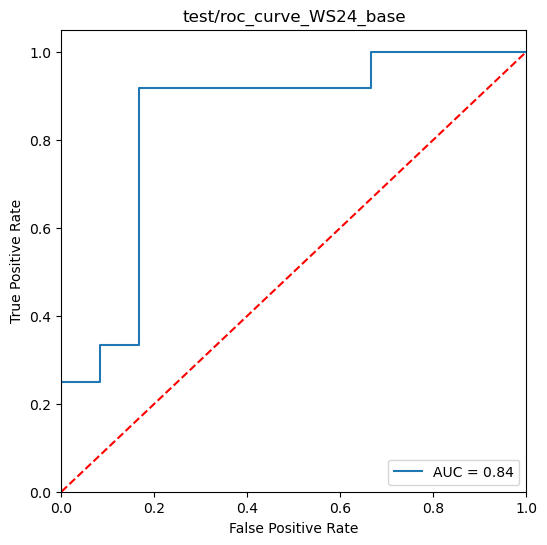

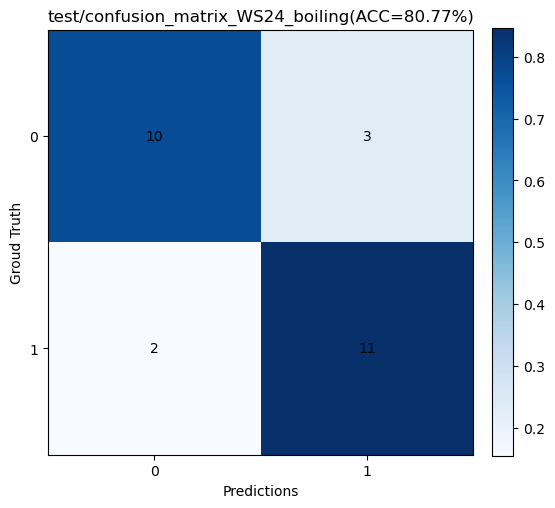

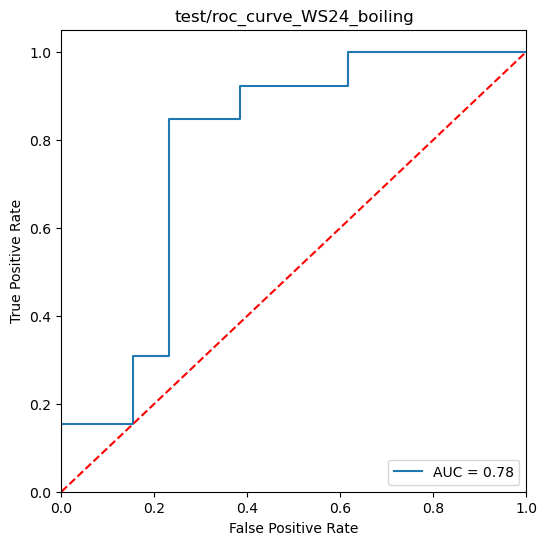

In [39]:
res = {}
result_dir = Path("./CGCNN_MT/evaluation")

data_dirs = [
    "./CGCNN_MT/data/TSD",
    "./CGCNN_MT/data/SSD", 
    "./CGCNN_MT/data/WS24",
]
col2tasks = [
    {"Label": "TSD"},
    {"Label": "SSD"},
    {"water_label": "WS24_water", "water4_label": "WS24_water4", "acid_label": "WS24_acid", "base_label": "WS24_base", "boiling_label": "WS24_boiling"},
    ]

tasks = [
    "TSD_SSD_WS24_water_WS24_water4", 
    "WS24_all",
    "TSD_SSD_WS24_all_attn"
]
metric_collections = []
for task in tasks:
    model_dir = task2models[task]["Path"]
    if task in ["TSD_SSD_WS24_all_attn"]:
        model_name = "MOFSNN_full"
    else:
        model_name = "MOFSNN_" + task
    version_name = Path(model_dir).name
    for col2task, data_dir in zip(col2tasks, data_dirs):
        for split in ["test"]:
            all_outputs, all_metrics = predict_main(model_dir, data_dir, col2task, split=split, result_dir=result_dir)
            if all_metrics:
                all_metrics = {k.replace(f"{split}_", "") : v for k,v in all_metrics.items()}
                all_metrics.update({"Model": model_name, "Version": version_name, "Split": split})
                metric_collections.append(all_metrics)

In [40]:
metric_collections

[{'TSD/R2Score': 0.4486852810190125,
  'TSD/MeanAbsoluteError': 46.24155,
  'Model': 'MOFSNN_TSD_SSD_WS24_water_WS24_water4',
  'Version': 'version_13',
  'Split': 'test'},
 {'SSD/Accuracy': 0.7385321100917431,
  'SSD/BalancedAccuracy': 0.7259060638695356,
  'SSD/F1Score': 0.7263477801268499,
  'SSD/MatthewsCorrCoef': 0.45272848228272855,
  'SSD/AUROC': 0.7916547616431131,
  'Model': 'MOFSNN_TSD_SSD_WS24_water_WS24_water4',
  'Version': 'version_13',
  'Split': 'test'},
 {'WS24_water/Accuracy': 0.7488584474885844,
  'WS24_water/BalancedAccuracy': 0.737855655794587,
  'WS24_water/F1Score': 0.7382944052145572,
  'WS24_water/MatthewsCorrCoef': 0.47662176469309114,
  'WS24_water/AUROC': 0.8298056904927135,
  'WS24_water4/Accuracy': 0.6621004566210046,
  'WS24_water4/BalancedAccuracy': 0.6175277833328572,
  'WS24_water4/F1Score': 0.5897032579069121,
  'WS24_water4/MatthewsCorrCoef': 0.4562669555543503,
  'WS24_water4/AUROC': 0.8230641341853238,
  'Model': 'MOFSNN_TSD_SSD_WS24_water_WS24_wat

In [47]:
reversed_dict = {}
for metric_d in metric_collections:
    model = metric_d["Model"]
    version = metric_d["Version"]
    split = metric_d["Split"]
    for metric_name, metric_value in metric_d.items():
        if metric_name in ["Model", "Version", "Split"]:
            continue
        task_name, metric_name = metric_name.split("/")
        if (task_name, model, version, split) not in reversed_dict:
            reversed_dict[(task_name, model, version, split)] = {metric_name: metric_value}
        else:
            reversed_dict[(task_name, model, version, split)][metric_name] = metric_value
records = []
for k, v in reversed_dict.items():
    task_name, model, version, split = k
    v.update({"Model": model, "Version": version, "Split": split, "Task": task_name})
    records.append(v)
df_res = pd.DataFrame(records)
model_map = {
    "MOFSNN_TSD_SSD_WS24_water_WS24_water4": "MOFSNN_no_small_set",
    "MOFSNN_WS24_all": "MOFSNN_no_weak_corr",
    "MOFSNN_full": "MOFSNN"
    
}
metric_name_map = {
    "R2Score": "R2",
    "MeanAbsoluteError": "MAE",
    "Accuracy": "ACC",
    "BalancedAccuracy": "BACC",
    "F1Score": "F1",
    "MatthewsCorrCoef": "MCC",
}
df_res["Model"] = df_res["Model"].map(model_map).copy()
df_res.rename(columns=metric_name_map, inplace=True)
for split in df_res["Split"].unique():
    print(f"Split: {split}")
    sub_df = df_res[df_res["Split"] == split].copy()
    sub_df.set_index(["Task", "Model"], inplace=True)
    sub_df.sort_index(inplace=True)
    sub_df.drop(columns=["Split", "Version", "F1", "MCC"], inplace=True)
    sub_df.to_excel(saved_dir/f"MOFSNN_subset_model_results_{split}.xlsx")

Split: test


In [48]:
metric_items = []
for i, row in sub_df.iterrows():
    
    for col in row.index:
        if pd.isna(row[col]):
            continue
        record = list(row.name)
        record.append(col)
        record.append(row[col])
        metric_items.append(record)


metric_df = pd.DataFrame(metric_items, columns=['Task', 'Model', 'Metric', 'Value'])
metric_df

,Task,Model,Metric,Value
0,SSD,MOFSNN,ACC,0.738532
1,SSD,MOFSNN,BACC,0.712060
2,SSD,MOFSNN,AUROC,0.769138
3,SSD,MOFSNN_no_small_set,ACC,0.738532
4,SSD,MOFSNN_no_small_set,BACC,0.725906
5,SSD,MOFSNN_no_small_set,AUROC,0.791655
6,TSD,MOFSNN,R2,0.448383
7,TSD,MOFSNN,MAE,45.197021
8,TSD,MOFSNN_no_small_set,R2,0.448685
9,TSD,MOFSNN_no_small_set,MAE,46.241550
